In [195]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from scipy.signal import butter, lfilter, filtfilt, savgol_filter, find_peaks
from sklearn.decomposition import FastICA, PCA
from collections import Counter


#folder_path = "data\heartbeat_data"
folder_path = "set-a-converted"

def load_mat_files_from_path(path):
    folder_dir = Path.cwd() / Path(path)
    mat_files = []
    for file_path in folder_dir.glob("*.mat"):
        mat_data = sio.loadmat(file_path)
        mat_files.append(mat_data["val"])
    return mat_files # inhomogenous shapes

data_arr = load_mat_files_from_path(folder_path)
print(np.shape(data_arr))

(25, 4, 60000)


In [196]:
min_len = 99999999
max_len = -1
for i in range(len(data_arr)):
    if len(data_arr[i]) < min_len:
        min_len = len(data_arr[i])
    if len(data_arr[i]) > max_len:
        max_len = len(data_arr[i])
print(min_len, max_len)

4 4


In [197]:

def normalize_all_channels(data):
    # takes mean and std of all data points and normalizes the channels by those
    temp_data = data.reshape(-1)
    mean = np.mean(temp_data)
    std = np.std(temp_data)
    temp_data = (temp_data - mean) / std
    return temp_data.reshape(4,-1)

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter(order, cutoff, fs=fs, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

def highpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    high = cutoff / nyquist
    b, a = butter(order, high, btype='high')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

<Figure size 640x480 with 0 Axes>

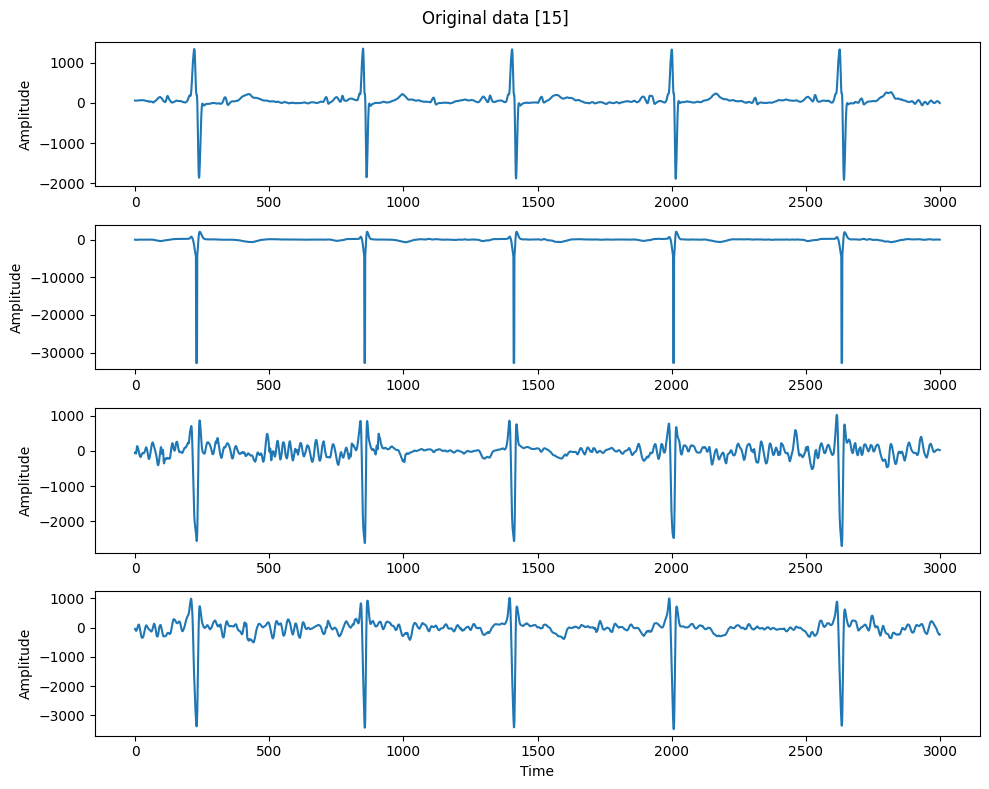

In [222]:
from matplotlib.patches import Patch
def plot_data_channels(data, suptitle, save=False, fileName=None, interval=None, ylabels=None, legend_items=None):
    plt.clf()
    plt.figure(figsize=(10, 2*data.shape[0]))
    plt.suptitle(suptitle)
    for i in range(data.shape[0]):
        plt.subplot(data.shape[0], 1, i + 1)
        if interval is not None:
            plt.plot(data[i][interval[0]:interval[1]])
        else:
            plt.plot(data[i])
        if(i == data.shape[0] - 1):
            plt.xlabel("Time")
        if ylabels is not None:
            plt.ylabel(ylabels[i])
        else:
            plt.ylabel("Amplitude")
        if legend_items is not None:
            legend_elements = [
                Patch(facecolor="blue", label=name)
                for name in legend_items
            ][::-1]
            plt.legend(handles=[legend_elements[i]])
    plt.tight_layout()
    if save:
        if fileName is not None:
            plt.savefig(f"{fileName}.png")
        else:
            plt.savefig(f"{i}.png")
        plt.clf()
    else:
        plt.show()

num = 15
plot_data_channels(data_arr[num], f"Original data [{num}]", interval=(0, 3000))

In [199]:
def do_ica(data):
    return FastICA(n_components=4).fit_transform(data.T).T

In [200]:
def correct_channel_sign(ica_out):
    for i in range(ica_out.shape[0]):
        if np.abs(np.max(ica_out[i])) < np.abs(np.min(ica_out[i])):
            #print("flipped")
            ica_out[i] *= -1
    return ica_out

In [201]:

# Function to detect peaks using the Pan-Tompkins algorithm
def detect_peaks_pan_tompkins(spike_channels, fs=360, threshold_factor=0.8):
    spiketimes = []
    for signal in spike_channels:
        # 1. Derivative
        derivative = np.diff(signal)

        # 2. Squaring
        squared = derivative ** 2

        # 3. Moving-window integration (using convolution)
        window_size = int(0.15 * fs) # ~54 samples for fs=360
        window = np.ones(window_size) / window_size
        integrated = np.convolve(squared, window, 'same')

        # 4. Thresholding
        threshold = threshold_factor * np.mean(integrated)
        peaks_indices, _ = find_peaks(integrated, height=threshold)
        spiketimes.append(peaks_indices)

    return spiketimes

In [202]:
from scipy.stats import zscore

def detect_peaks_simple(spike_channels, threshold_factor=0.4, distance=40, prominence=2.2, width=(None,30), zscore_threshold=0.5):
    #tmp = np.copy(spike_channels)
    spiketimes = []
    for signal in spike_channels:
        scores = zscore(signal)
        outliers = np.where(np.abs(scores) > zscore_threshold)
        signal[outliers] = 0

        threshold = threshold_factor * np.max(signal)
        peaks_indices, _ = find_peaks(signal, height=threshold, distance=distance, prominence=prominence, width=width)
        spiketimes.append(peaks_indices)
    return spiketimes

In [ ]:
def plot_data_channels_with_spiketimes(data, suptitle, spiketimes, save=False, fileName=None, ylabels=None, interval=None):
    plt.clf()
    plt.figure(figsize=(10, 2*data.shape[0]))
    plt.suptitle(suptitle)
    for i in range(data.shape[0]):
        plt.subplot(data.shape[0], 1, i + 1)
        if interval is not None:
            plt.plot(data[i][interval[0]:interval[1]])
            #if len(spiketimes[i]) > 0:
            #    plt.plot(spiketimes[i], data[i][interval[0]:interval[1]][spiketimes[i]], 'x')
        else:
            plt.plot(data[i])
            if len(spiketimes[i]) > 0:
                plt.plot(spiketimes[i], data[i][spiketimes[i]], 'x')
        if(i == data.shape[0] - 1):
            plt.xlabel("Time")
        if ylabels is not None:
            plt.ylabel(ylabels[i])
        else:
            plt.ylabel("Amplitude")
    plt.tight_layout()
    if save:
        if fileName is not None:
            plt.savefig(f"{fileName}.png")
        else:
            plt.savefig(f"{i}.png")
        plt.clf()
    else:
        plt.show()  

In [204]:
def minimum_difference(arr):
    min_diff = float('inf')
    min_indices = (None, None)

    for i in range(len(arr)):
        for j in range(i + 1, len(arr)):
            diff = abs(arr[i] - arr[j])
            if diff < min_diff:
                min_diff = diff
                min_indices = (i, j)

    return min_indices, min_diff

[2 0]
90 0.2505310051724313 0.3940486547968982
17 0.7165888099046961 1.0331553375563731
89 0.3141637152537567 0.4083398930494162
2 0.5843375815099583 0.0


<Figure size 640x480 with 0 Axes>

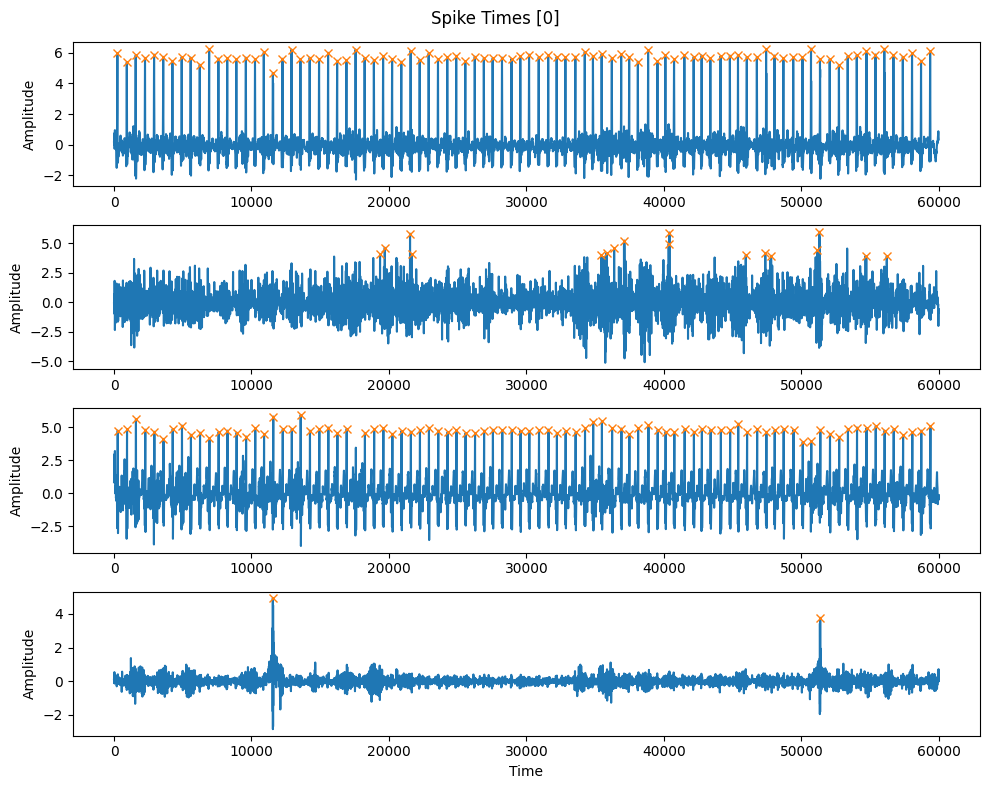

(0, 2)
95 0.18945750125352387 0.2559648173594499
68 0.46966629867876314 0.5811228333907998
95 0.40877654647294986 0.5511506883334011
23 0.5679543652837049 0.8674195759693051


<Figure size 640x480 with 0 Axes>

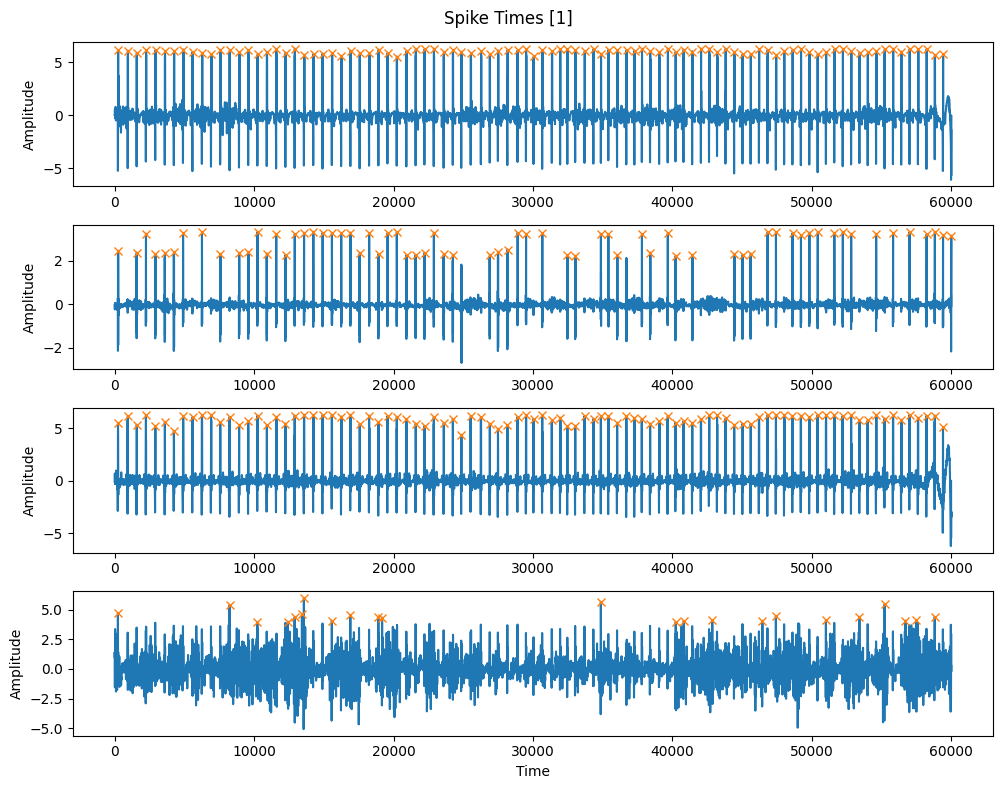

(1, 2)
40 0.5197957718759765 0.6260686417026218
110 0.16455600729347528 0.2273255474264449
110 0.10625711833911766 0.14365030103520737
48 0.4111194731315265 0.6334971725575722


<Figure size 640x480 with 0 Axes>

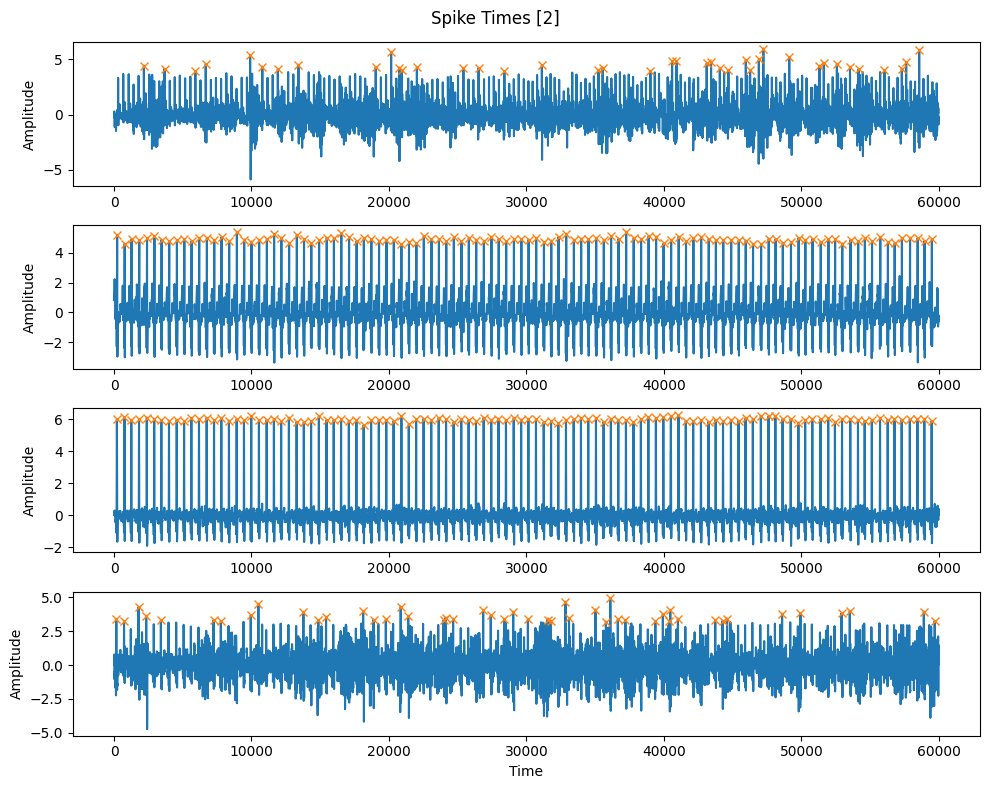

(1, 2)
27 0.7160444132641781 0.9785127441650179
100 0.12796854173445574 0.18400792854180048
100 0.14192635832958003 0.17645756661122156
14 0.507372914379144 0.5486306275594344


<Figure size 640x480 with 0 Axes>

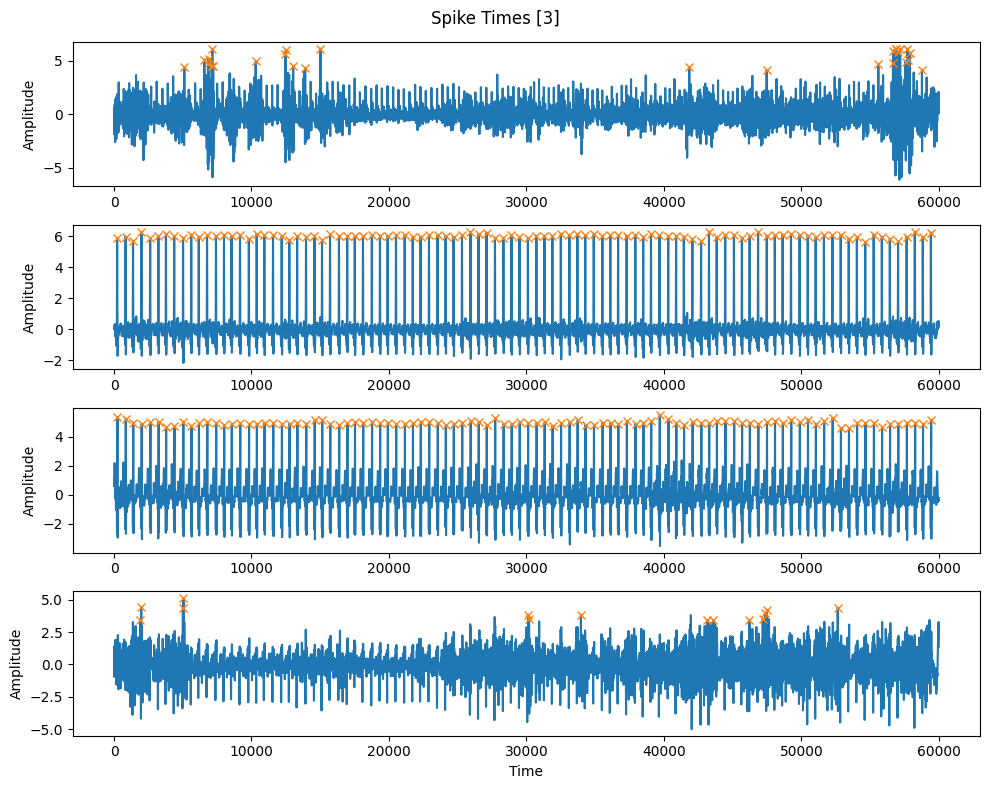

(2, 3)
5 0.46621971395519407 0.6584302475312046
38 0.5480295029197385 0.7345084704136161
90 0.2244679142743205 0.36706161129593734
90 0.11369946145957108 0.16747181194397143


<Figure size 640x480 with 0 Axes>

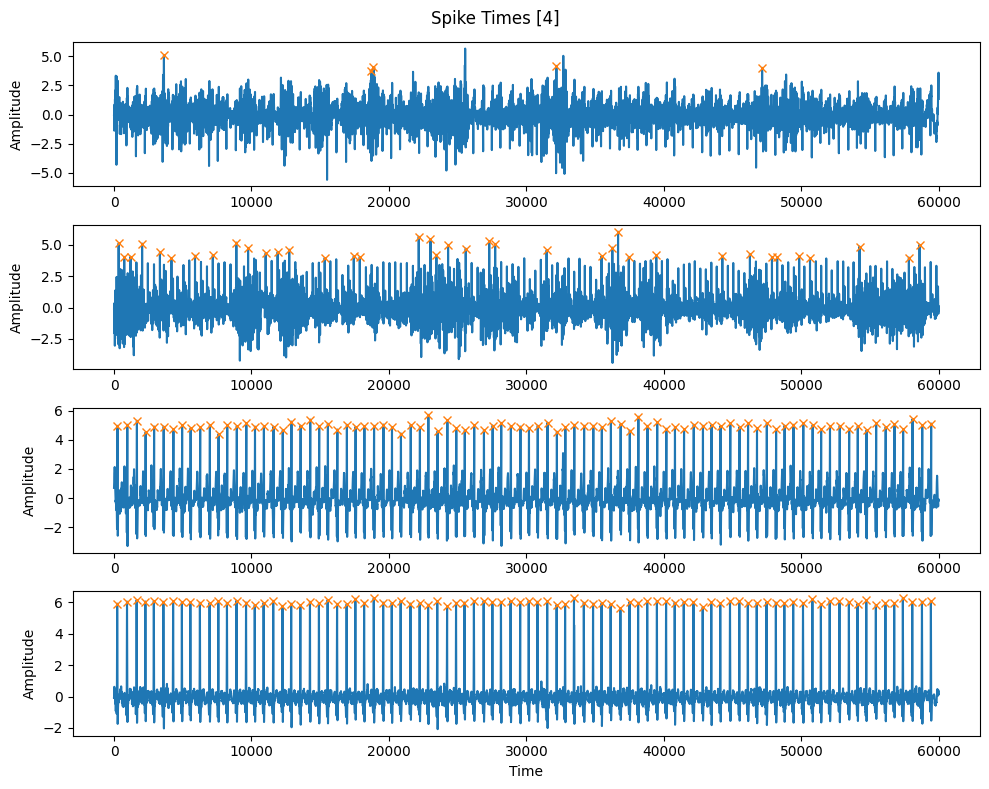

(2, 3)
6 0.3665866230206215 0.6250795735062783
93 0.441212692484602 0.6170654668942303
80 0.11972530513485835 0.17171855246915507
80 0.24658877234720153 0.32181520659192553


<Figure size 640x480 with 0 Axes>

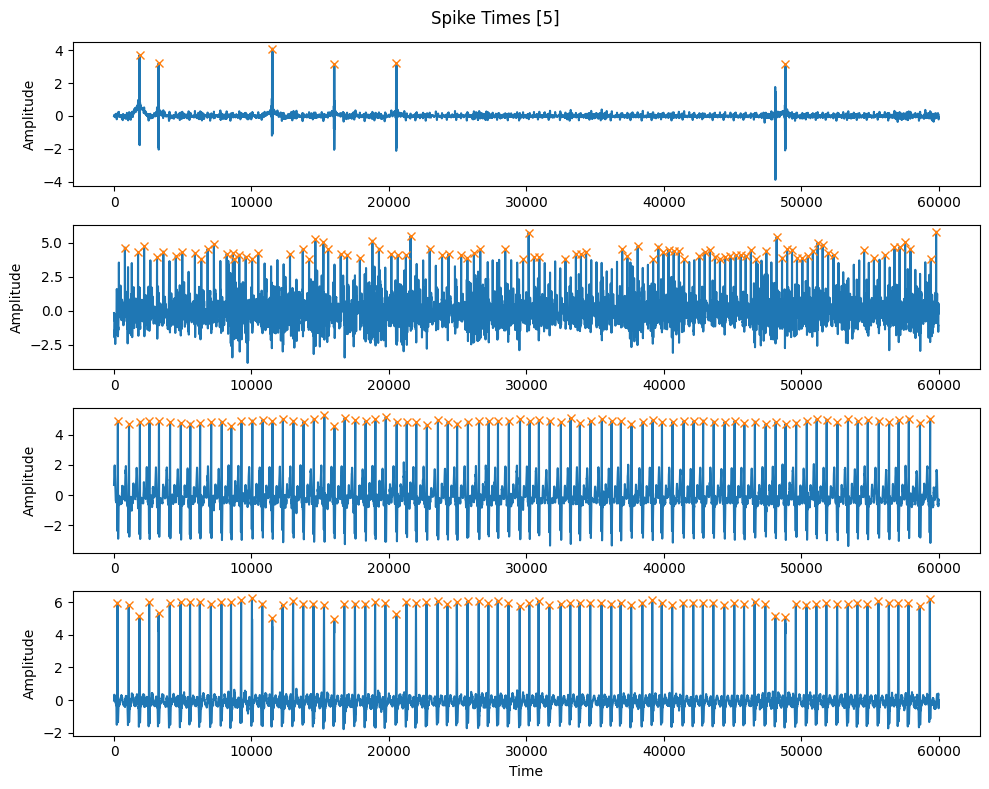

(2, 3)
40 0.19670197644858647 0.23181283623873727
17 0.4152498274557202 0.581629140800087
2 0.12211466392989878 0.0
2 0.07676813861032494 0.0


<Figure size 640x480 with 0 Axes>

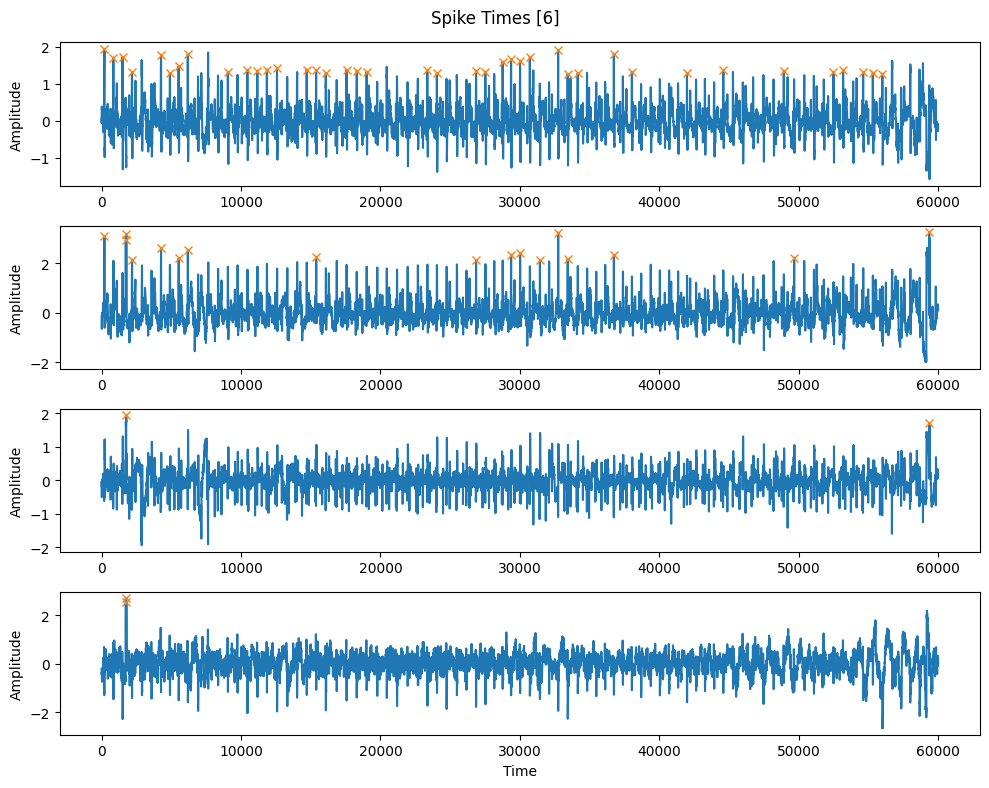

(1, 3)
56 0.4813492936286586 0.6776604967153119
90 0.17889347118959412 0.2332354048360797
7 0.5649601986370776 0.41176110620845957
90 0.1567090980644022 0.21577739794429418


<Figure size 640x480 with 0 Axes>

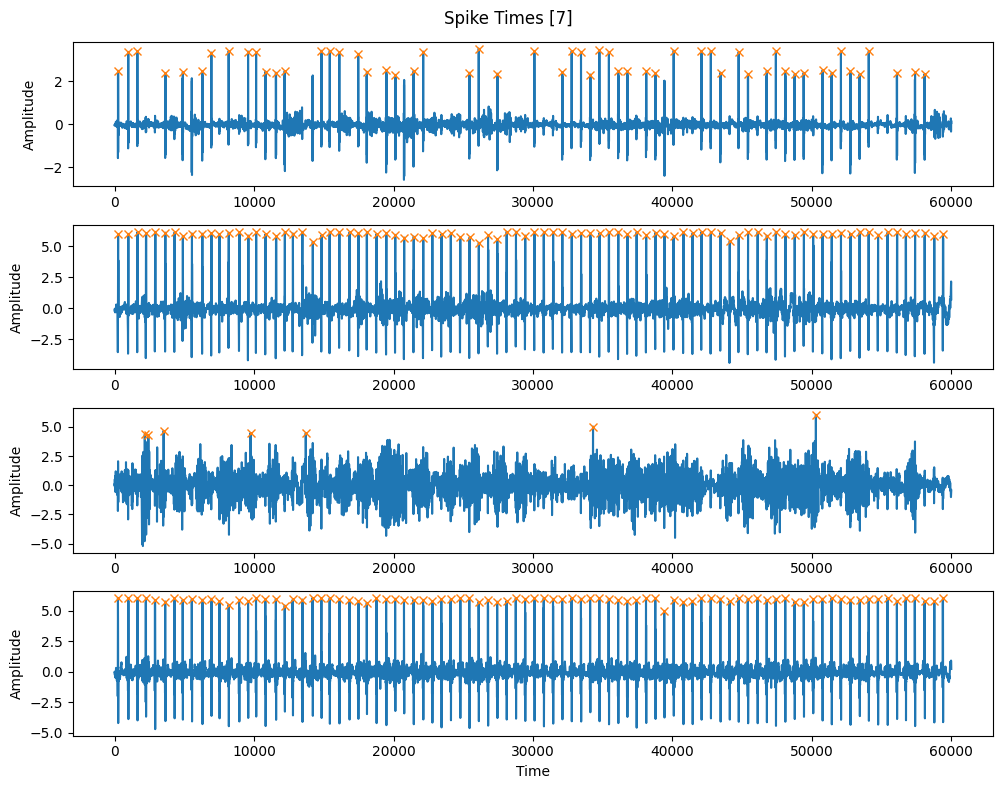

[2 1]
0 nan nan
81 0.5689611787584877 0.3354922862785454
13 0.3641500260025328 0.41199190187793694
1 0.0 nan


/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

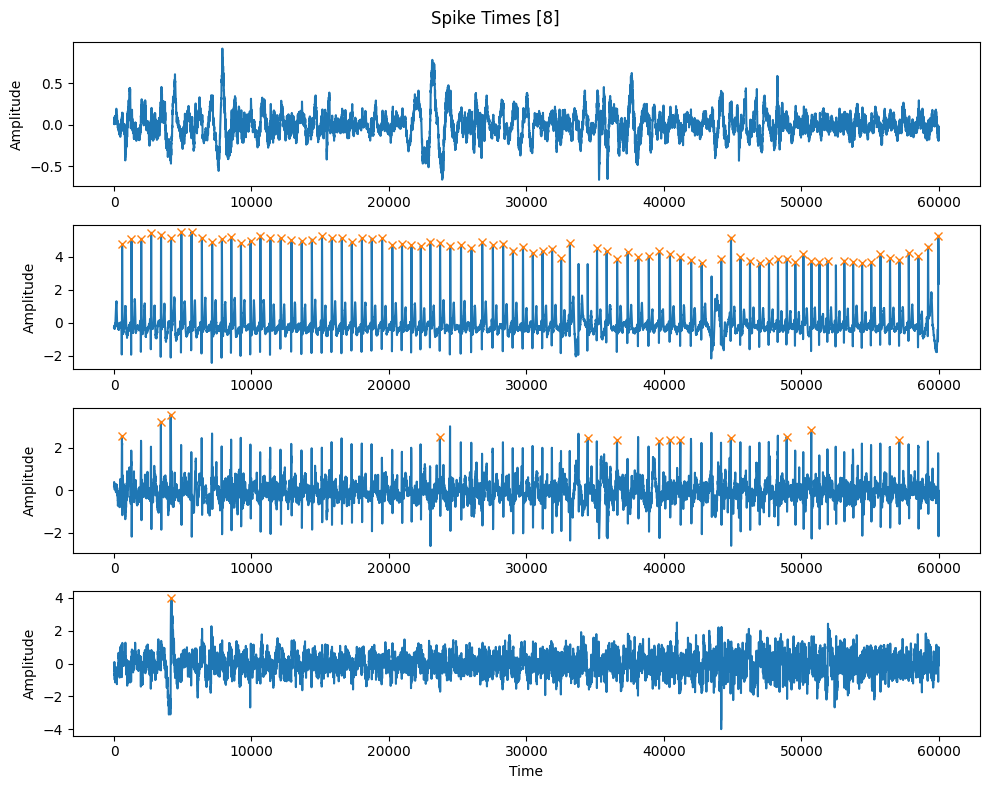

[3 0]
77 0.3229674880151662 0.1646095989711893
0 nan nan
0 nan nan
1 0.0 nan


/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

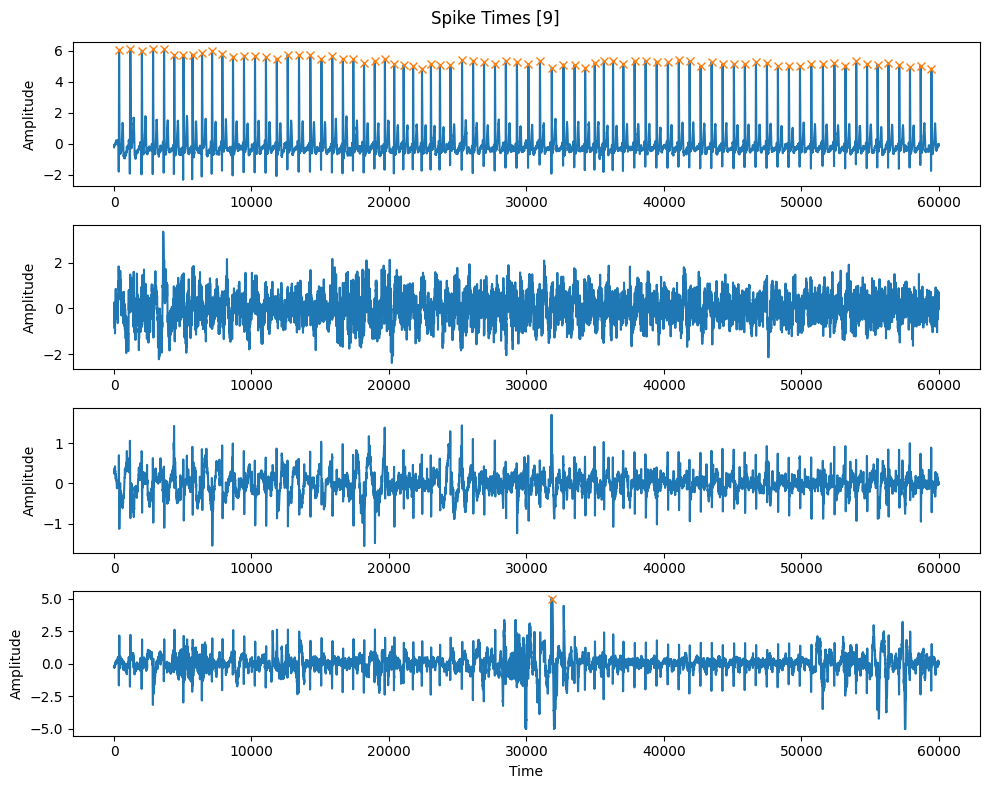

[2 1]
2 0.07884539059090534 0.0
72 0.3446711730430799 0.2816653207648212
11 0.4015378008801903 0.3142186854919817
7 0.6306714242014042 1.0182036092166917


<Figure size 640x480 with 0 Axes>

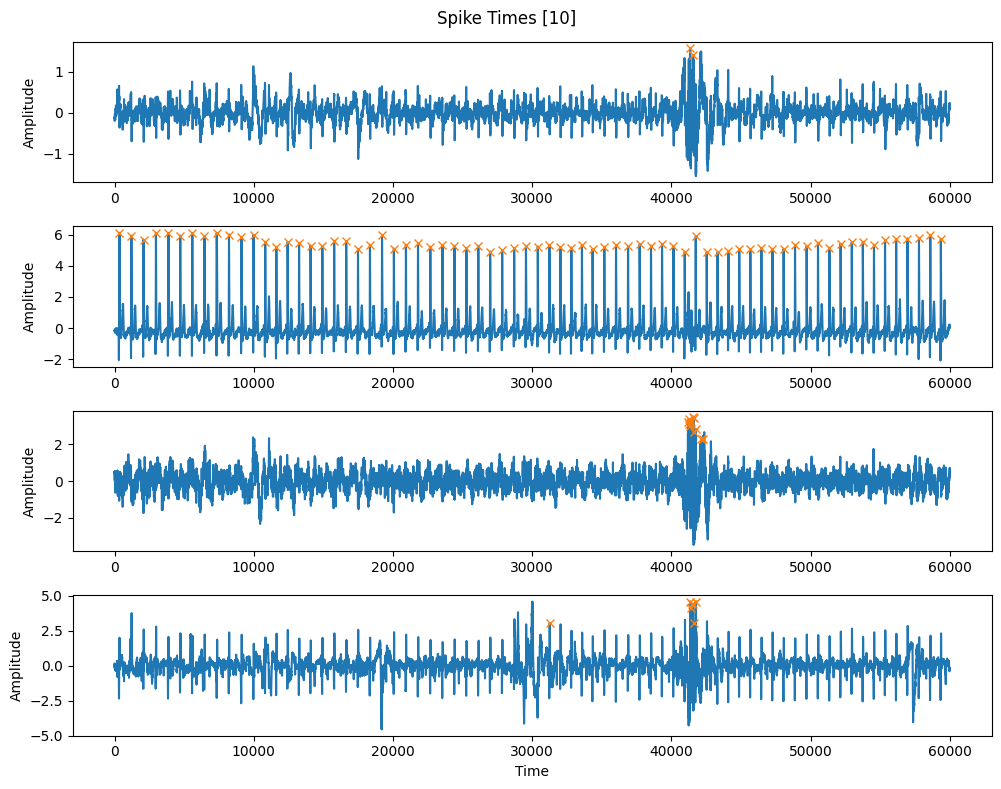

[1 0]
75 0.23299694725993714 0.2728346324385795
50 0.5091707204221784 0.5806672050826748
14 0.5164746641087841 0.6763045232924328
4 0.32843962894825285 0.5034143720068246


<Figure size 640x480 with 0 Axes>

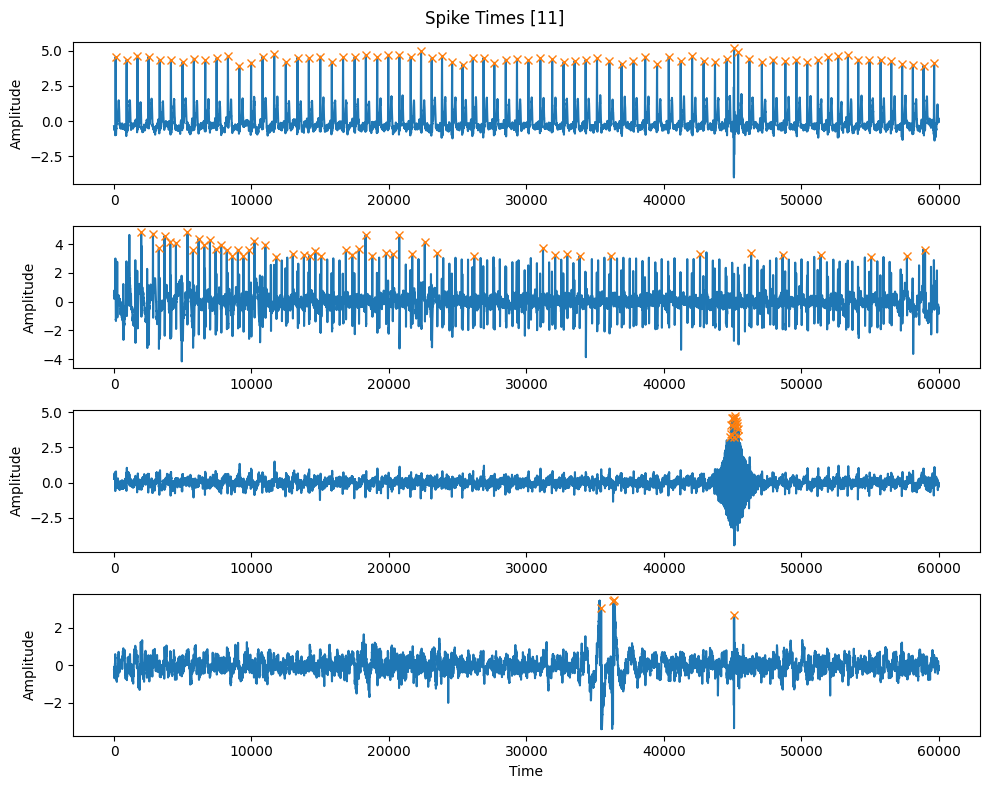

(0, 3)
101 0.3661607203642369 0.3634626782698504
2 0.10548746746133086 0.0
50 0.572513110235588 0.5826910541660505
101 0.34535694038457543 0.47552135729719885


<Figure size 640x480 with 0 Axes>

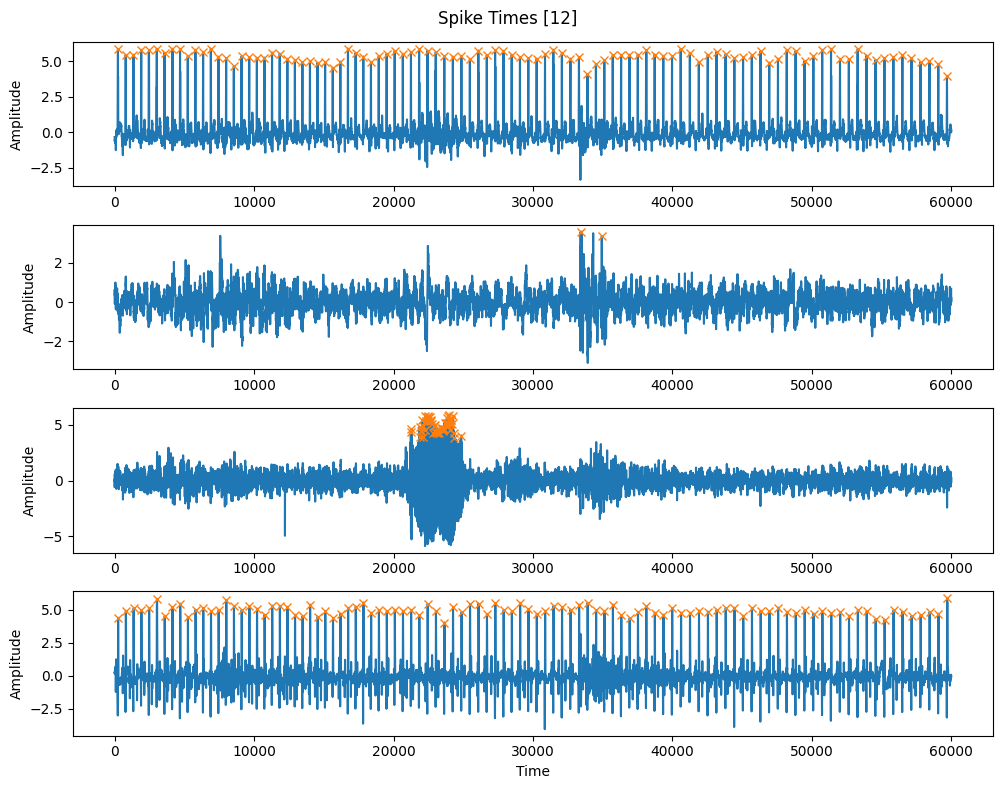

(0, 2)
125 0.17304654499932914 0.22889882017458663
93 0.15444894113282767 0.20512650512097
125 0.38454823268650173 0.47797109114127756
36 0.5127387205097245 0.7158937487147831


<Figure size 640x480 with 0 Axes>

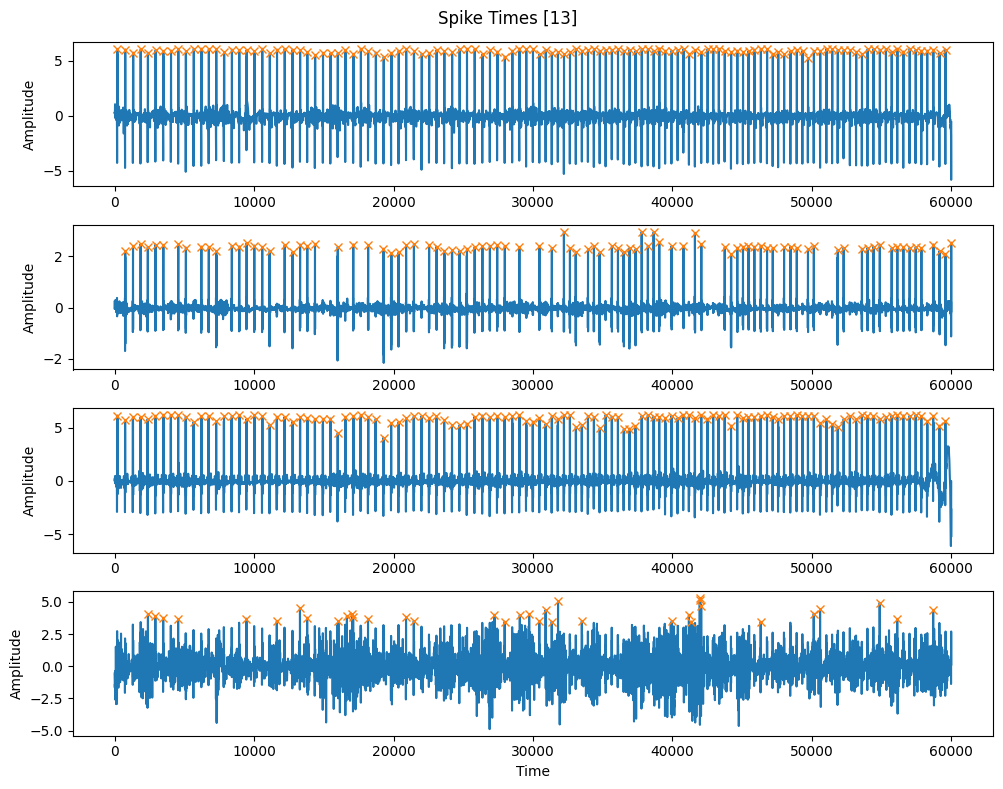

[2 0]
100 0.36366006193494527 0.471199427776777
16 0.2839351844061609 0.3687770666382943
95 0.3089853592154786 0.4596414507728516
41 0.5435845439069688 0.5510716019703821


<Figure size 640x480 with 0 Axes>

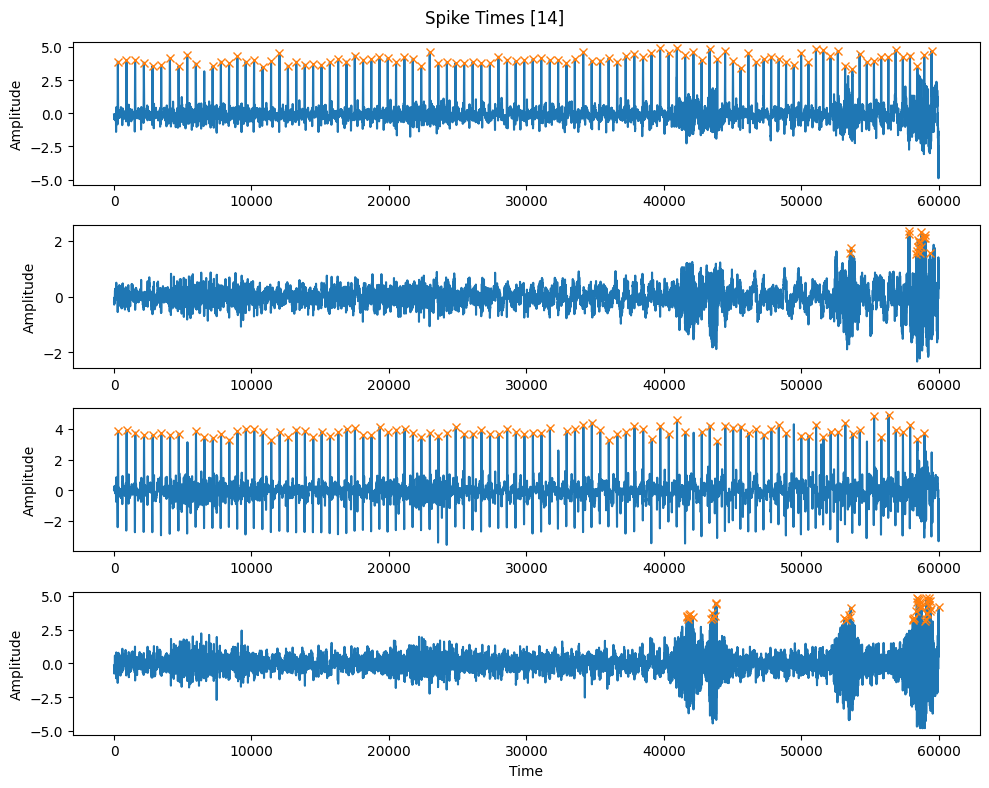

(0, 3)
111 0.1378408861672051 0.20828346642261114
107 0.4787625289406413 0.6338002524711228
10 0.5760366830588749 0.7578453287460197
111 0.17787918091843274 0.23616070551144835


<Figure size 640x480 with 0 Axes>

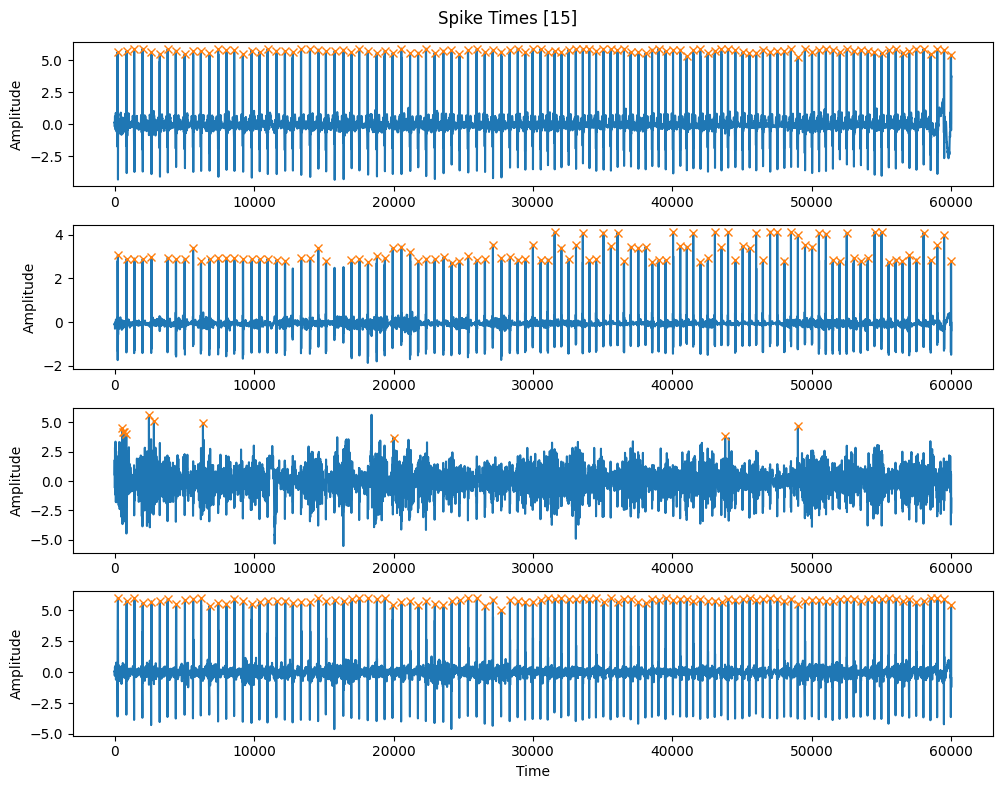

[0 1]
79 0.20137460104111576 0.2376531443829464
85 0.3636100743799754 0.5097116073747607
23 0.6057709591358068 0.5873817392418902
1 0.0 nan


/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

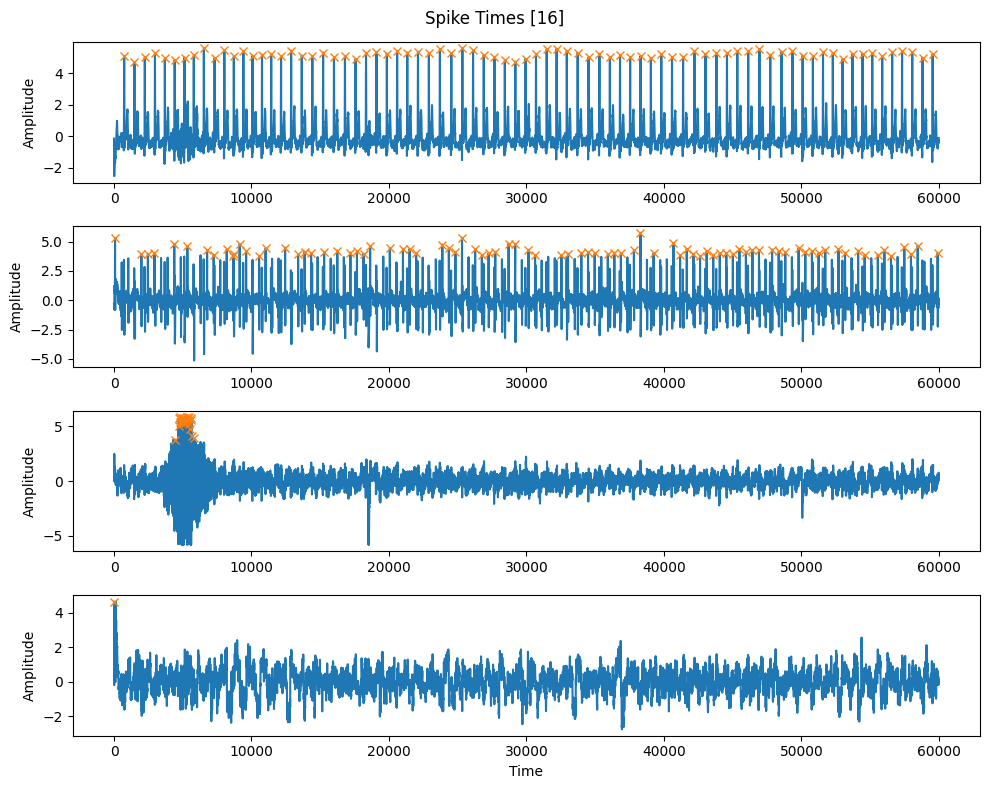

[3 1]
0 nan nan
81 0.2533018657838829 0.1903242145788312
0 nan nan
9 0.19096376432601259 0.3357386984614755


/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

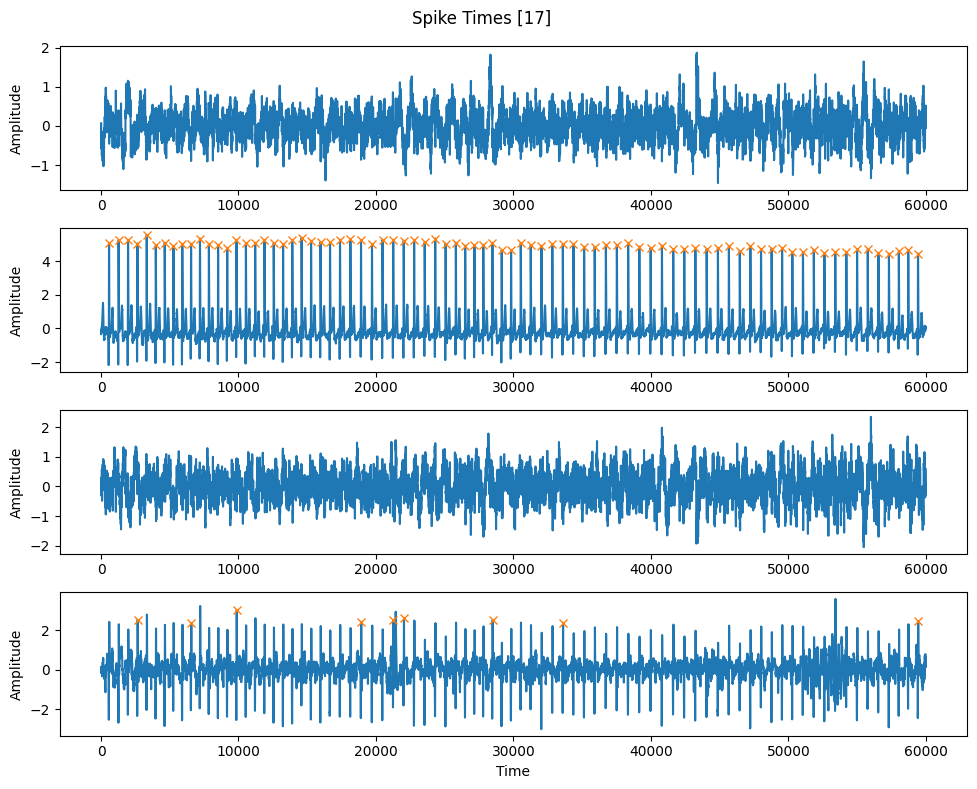

[3 2]
2 0.006642998565745684 0.0
1 0.0 nan
84 0.33535775960885145 0.4120148618848415
13 0.5937909302572716 1.0875630598939328


/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

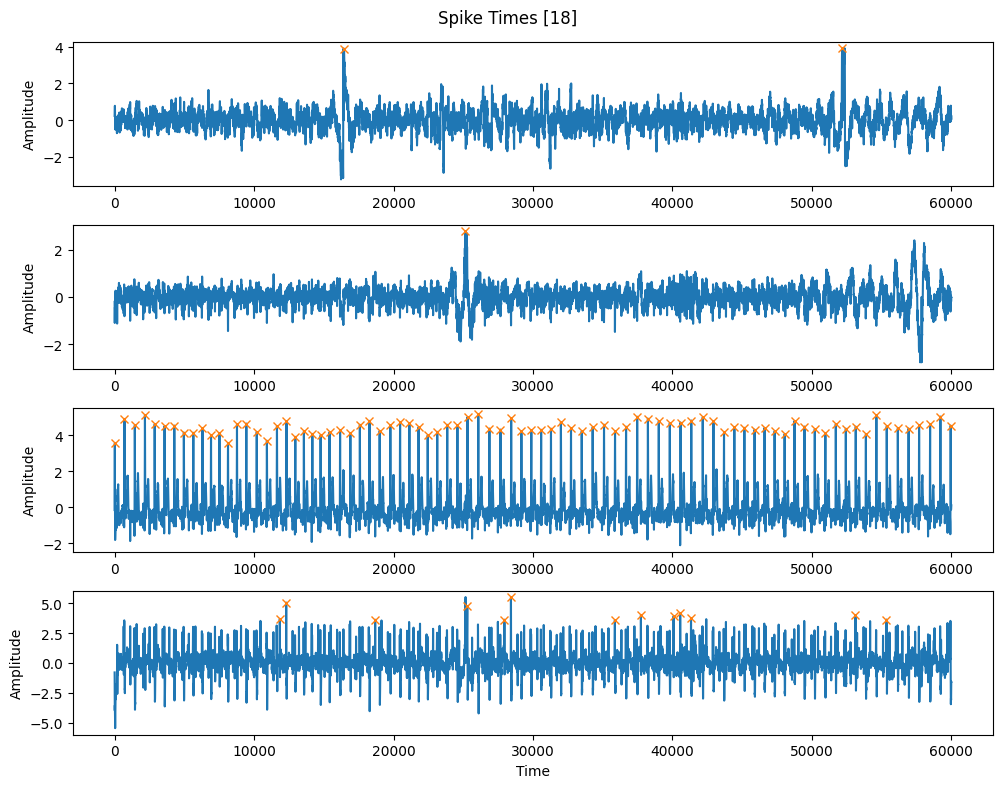

[0 3]
2 0.0052130592526926645 0.0
0 nan nan
0 nan nan
78 0.2336583216685034 0.2795970111463566


/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

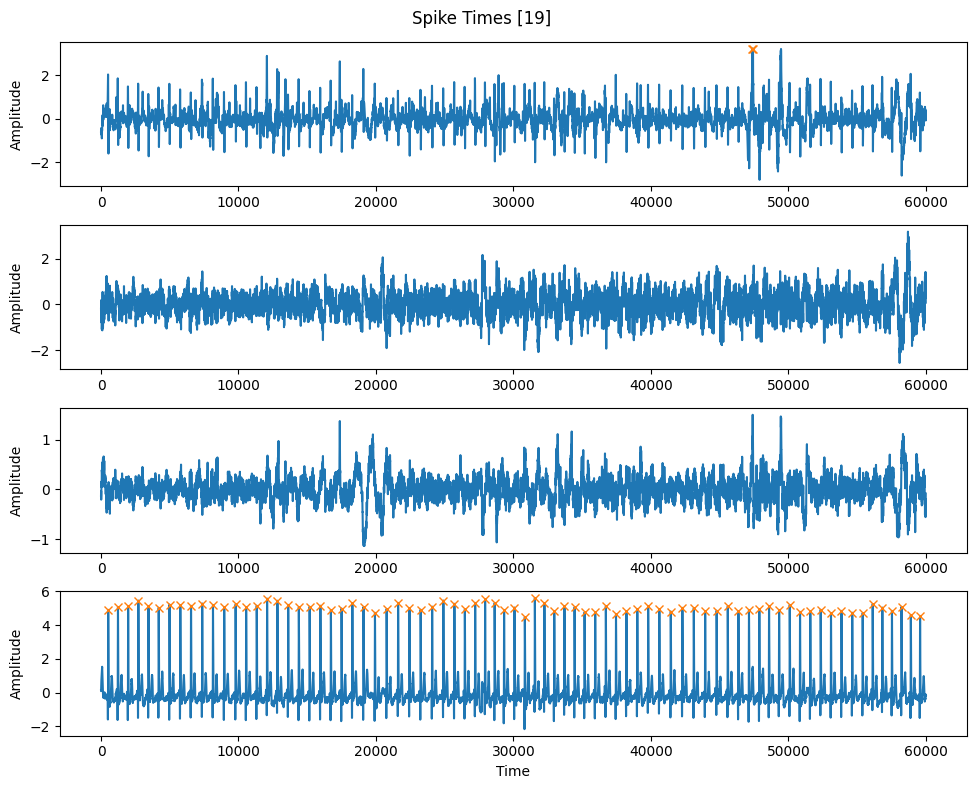

(1, 3)
95 0.493185098252317 0.5758514088391543
96 0.19288624540073326 0.2532385008069507
76 0.07393237105022975 0.09969568828613304
96 0.28729897206395566 0.373091421283509


<Figure size 640x480 with 0 Axes>

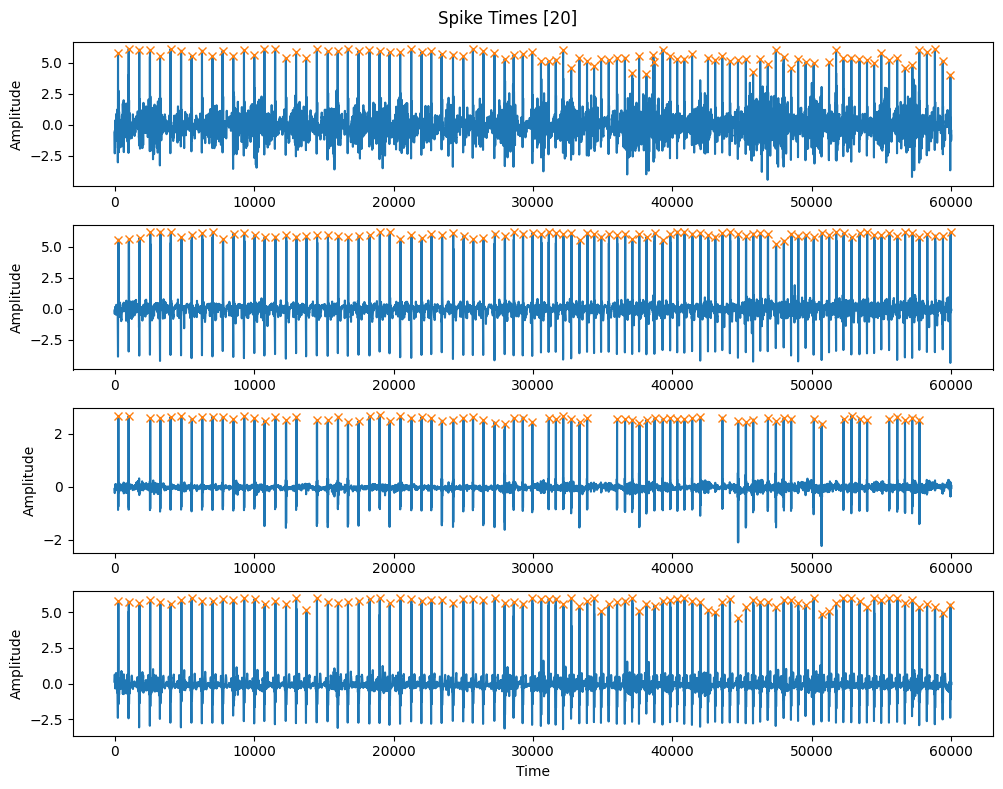

[1 3]
9 0.22956441786886614 0.35420197201424014
74 0.2781545549973579 0.30901909713373626
4 0.1286953523753021 0.1521049299021701
118 0.33545193950883795 0.49423870748434967


<Figure size 640x480 with 0 Axes>

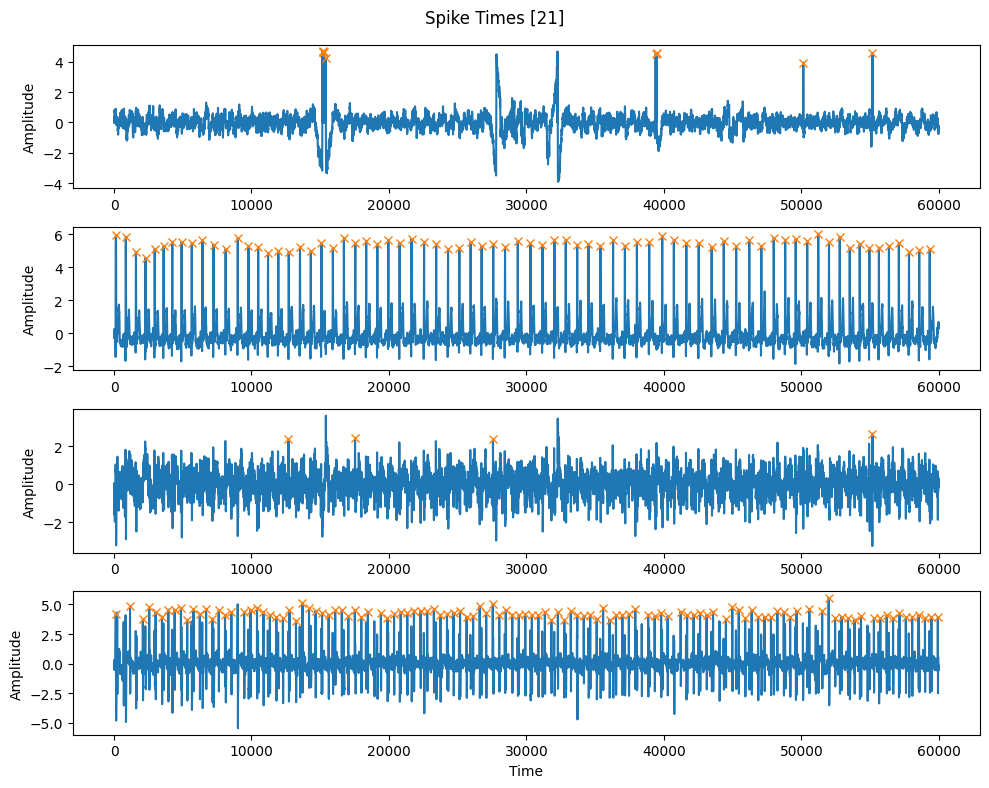

[1 0]
79 0.3703305323195288 0.3197501282917448
36 0.41459937772244476 0.4446090161283277
1 0.0 nan
0 nan nan


/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

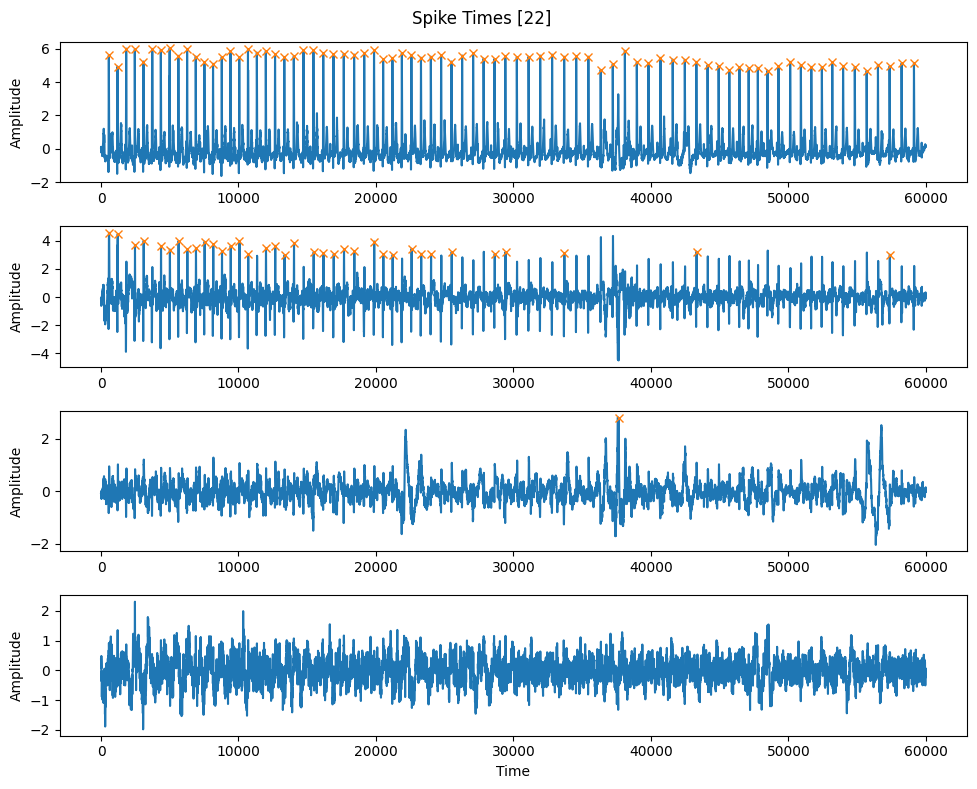

[1 2]
2 0.09394676344147612 0.0
34 0.49384987645455586 0.6320236103293493
80 0.3119387004986499 0.3957460903978665
0 nan nan


/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/denismeral/Desktop/Unsupervised_Group9/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

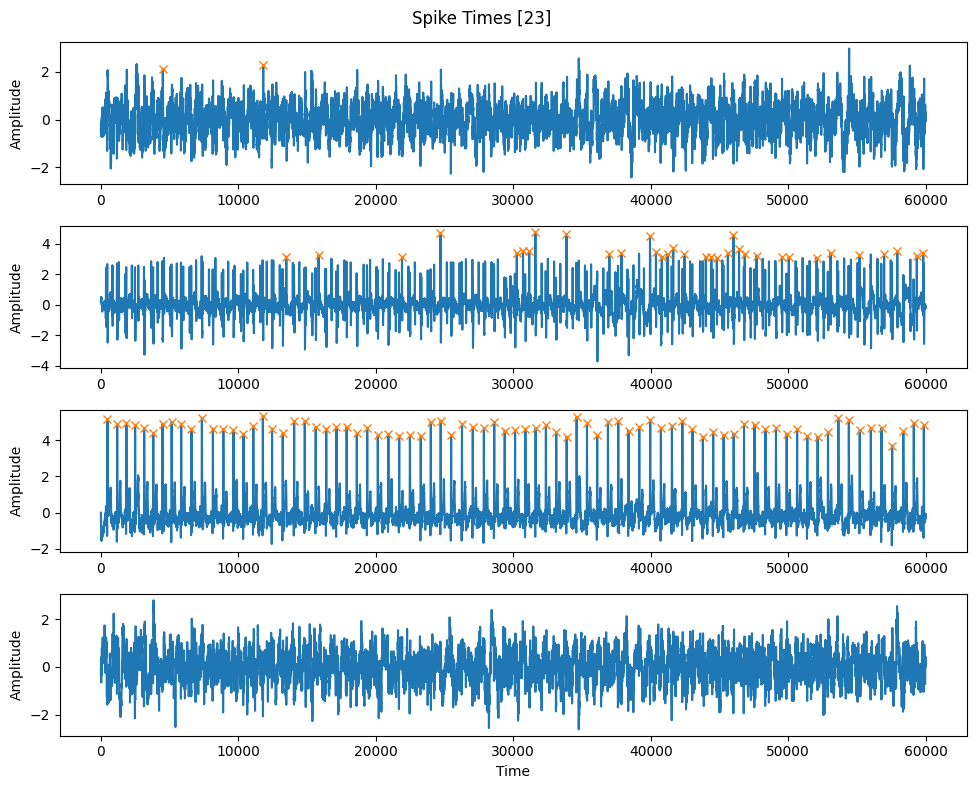

[0 3]
86 0.34991706107986054 0.42975261572180457
8 0.5462768907801369 0.8342976573560605
2 0.24179455638143177 0.0
87 0.23324000417484284 0.3015251366406133


<Figure size 640x480 with 0 Axes>

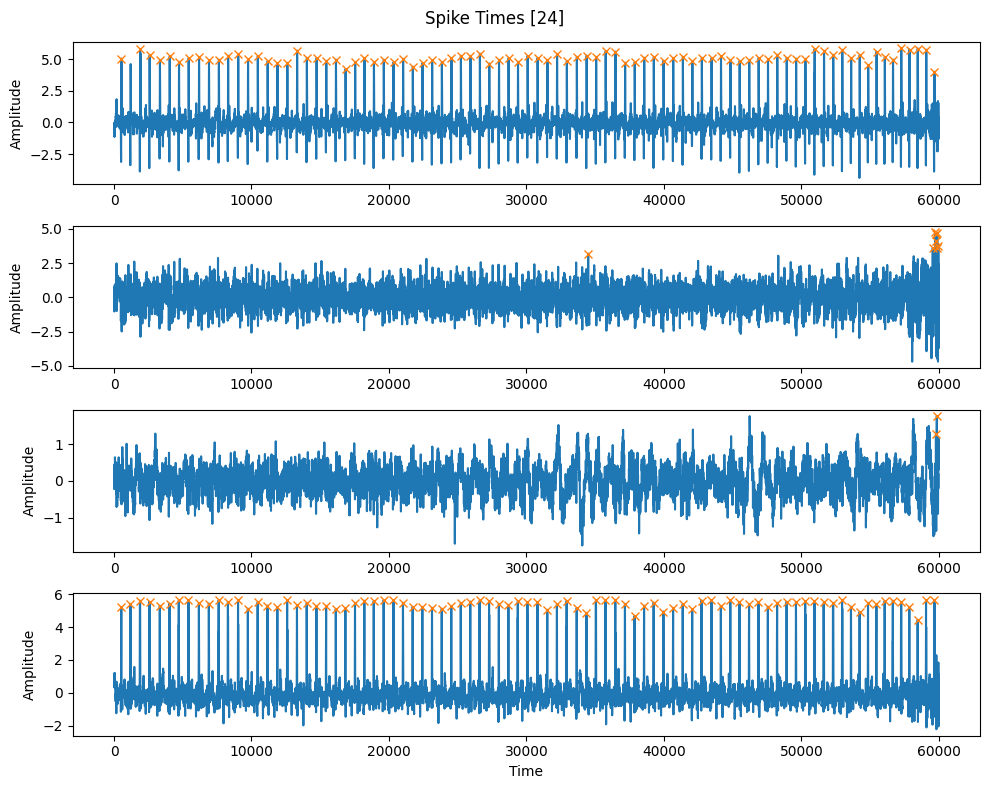

In [210]:
spike_channels_arr = []
spiketimes_arr = []
for i in range(len(data_arr)):#[5,17,35,36,90,128,131]:#
    data_normalized = normalize_all_channels(data_arr[i])

    ica_out = do_ica(data_normalized)
    #plot_data_channels(ica_out, f"ICA out [{i}]", interval=(0, 3000))#, save=True, fileName=f"ica_images/{i}")
    ica_corrected = ica_out
    for channel in range(ica_corrected.shape[0]):
        #ica_corrected[channel] = bandpass_filter(ica_corrected[channel], 0.4, 6, fs=1000)
        # spikes are very high frequency, so we must not cut them out and instead use a highpass filter to remove the low frequency noise
        #hp[channel] = highpass_filter(hp[channel], 0.8, fs=1000)
        ica_corrected[channel] = bandpass_filter(ica_corrected[channel], 0.8, 80, fs=1000)
    
    #plot_data_channels(ica_corrected, f"Bandpass-Filtered Signals [{i}]")#, save=True, fileName=f"ica_images/{i}")

    for signal_i in range(ica_corrected.shape[0]):
        scores = zscore(ica_corrected[signal_i])
        outliers = np.where(np.abs(scores) > 6.3)
        ica_corrected[signal_i][outliers] = 0
    #plot_data_channels(ica_corrected, f"ZScore-Filtered Signals [{i}]")#, save=True, fileName=f"ica_images/{i}")

    ica_corrected = correct_channel_sign(ica_out)
    #plot_data_channels(ica_corrected, f"Sign-Corrected ICA out [{i}]", save=True, fileName=f"ica_images/{i}")
    spike_channels = ica_corrected

    spiketimes = detect_peaks_simple(spike_channels, threshold_factor=0.65, zscore_threshold=99999, distance=30, prominence=2.1, width=(None,40))
    spikecounts = [len(spiketimes[j]) for j in range(len(spiketimes))]
    candidate_indices, candidate_diff = minimum_difference(spikecounts)
    if candidate_diff <= 0 and spikecounts[candidate_indices[0]] != 0:
        heartbeats = candidate_indices
    else:
        heartbeats = np.argsort(spikecounts)[2:]
    print(heartbeats)

    for j in range(len(spiketimes)):
        print(len(spiketimes[j]), np.std(ica_corrected[j][spiketimes[j]]), np.std(np.diff(ica_corrected[j][spiketimes[j]])))
    plot_data_channels_with_spiketimes(spike_channels, f"Spike Times [{i}]", spiketimes)#, save=True, fileName=f"ica_images/{i}")

    spike_channels_arr.append(spike_channels)
    spiketimes_arr.append(spiketimes)

<Figure size 640x480 with 0 Axes>

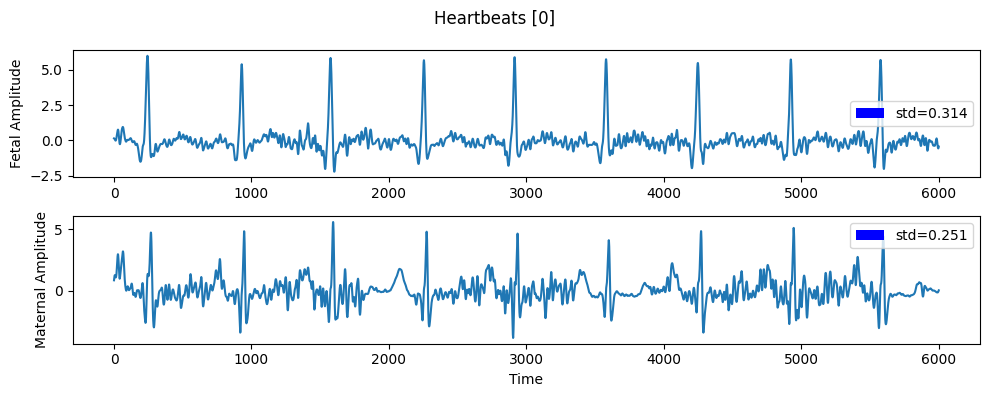

<Figure size 640x480 with 0 Axes>

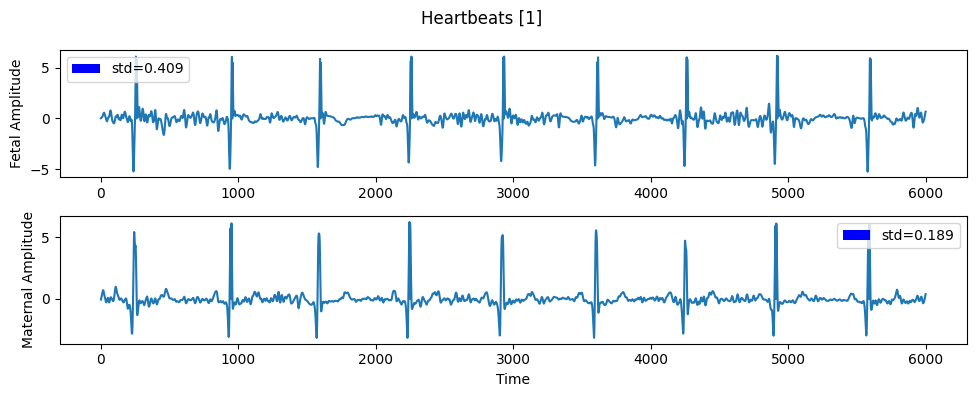

<Figure size 640x480 with 0 Axes>

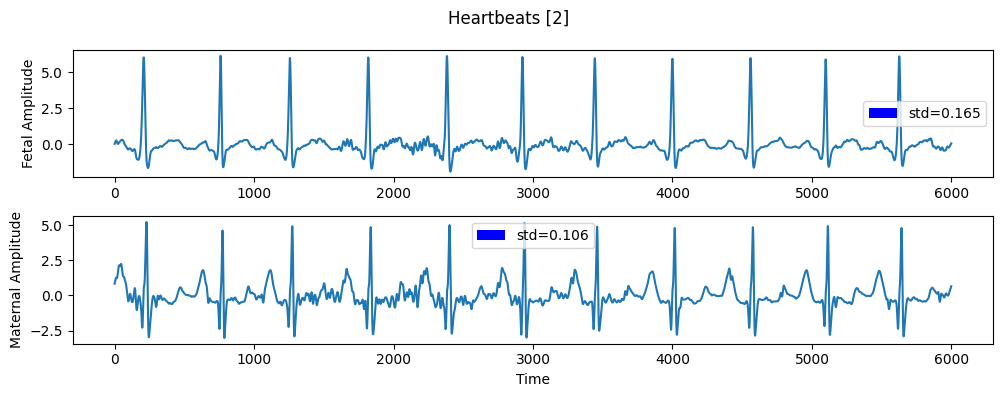

<Figure size 640x480 with 0 Axes>

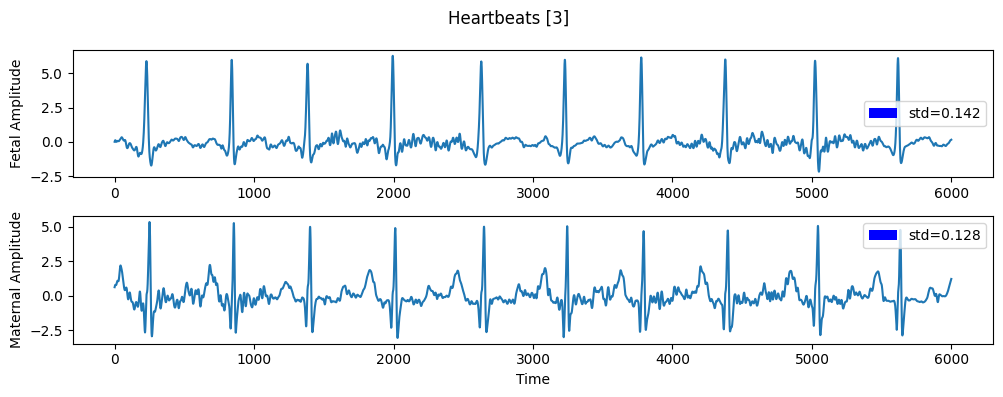

<Figure size 640x480 with 0 Axes>

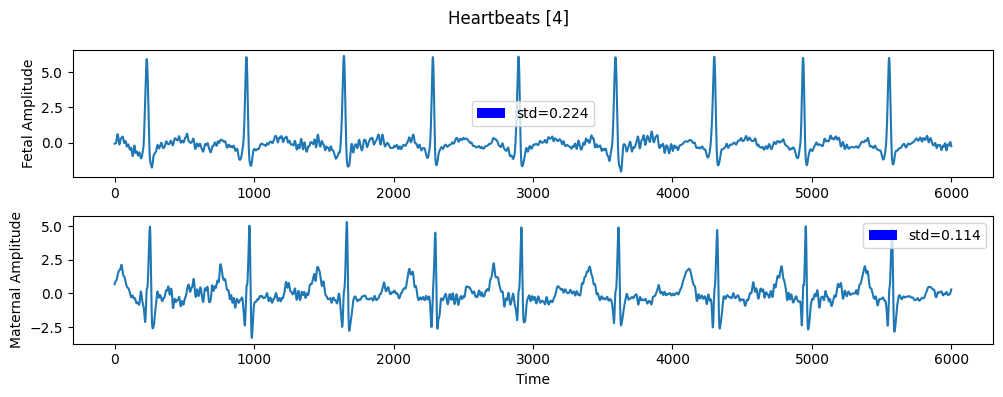

<Figure size 640x480 with 0 Axes>

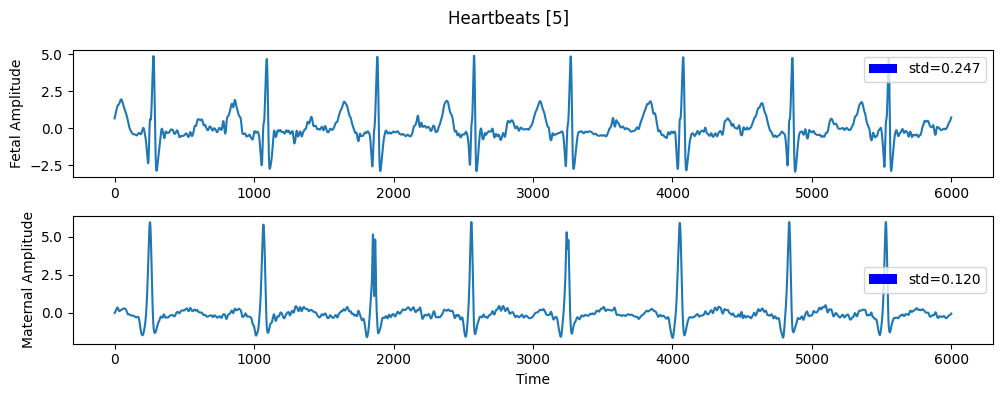

<Figure size 640x480 with 0 Axes>

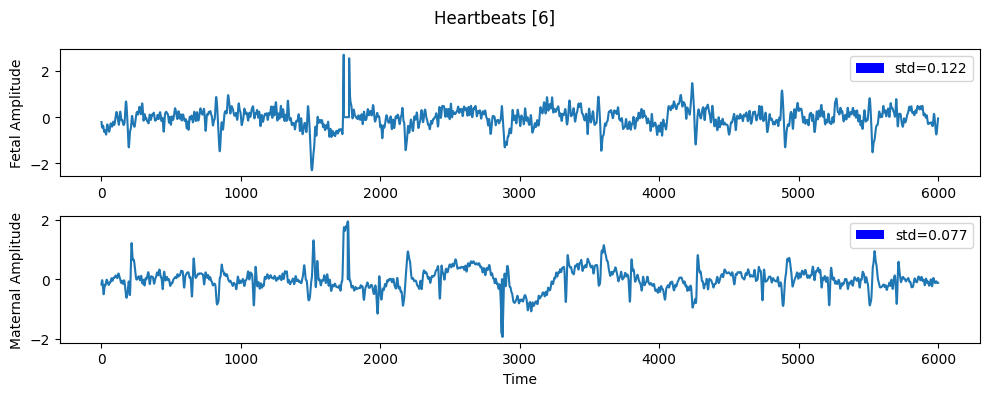

<Figure size 640x480 with 0 Axes>

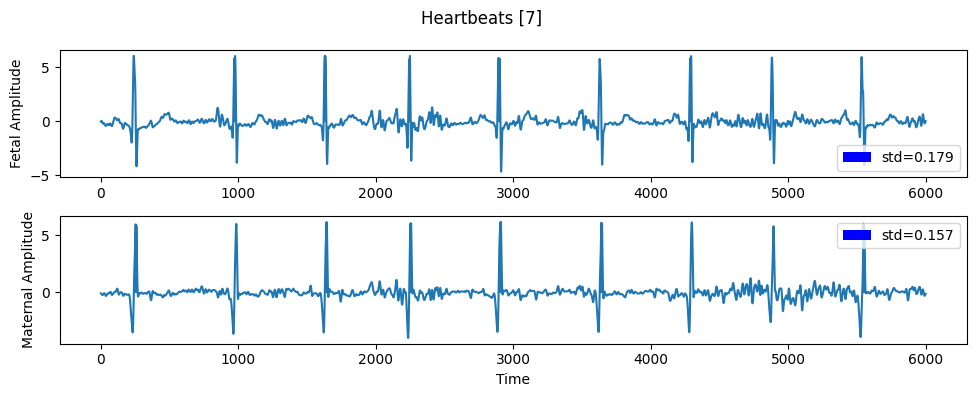

<Figure size 640x480 with 0 Axes>

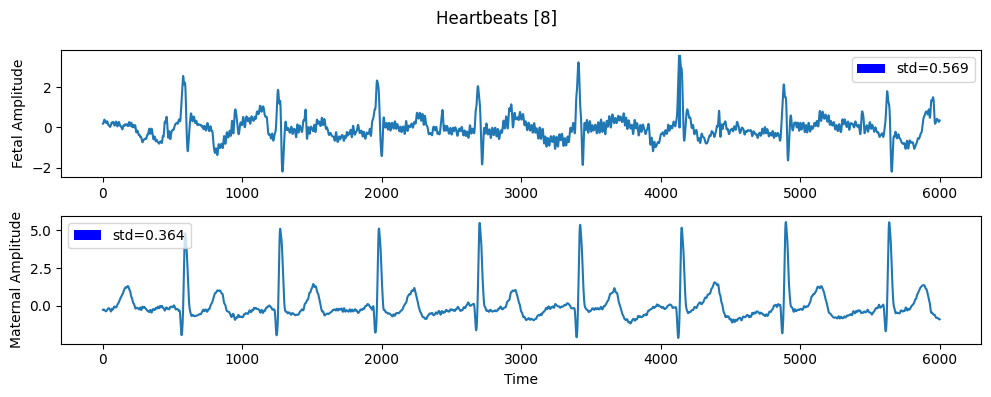

<Figure size 640x480 with 0 Axes>

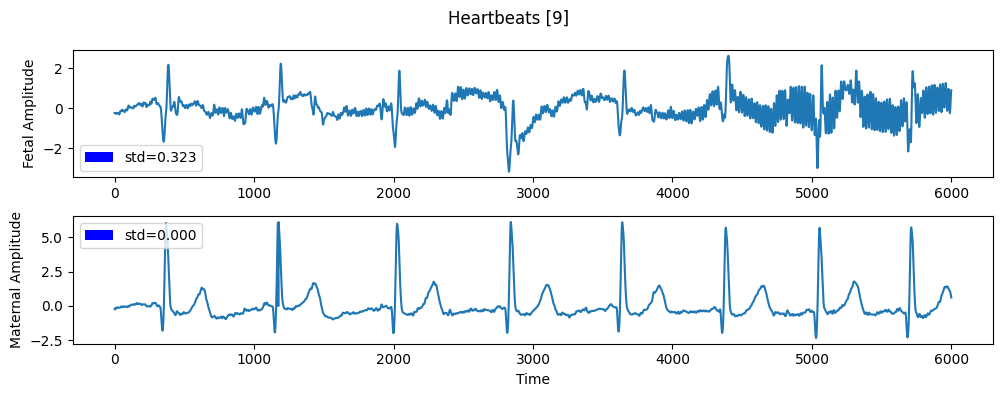

<Figure size 640x480 with 0 Axes>

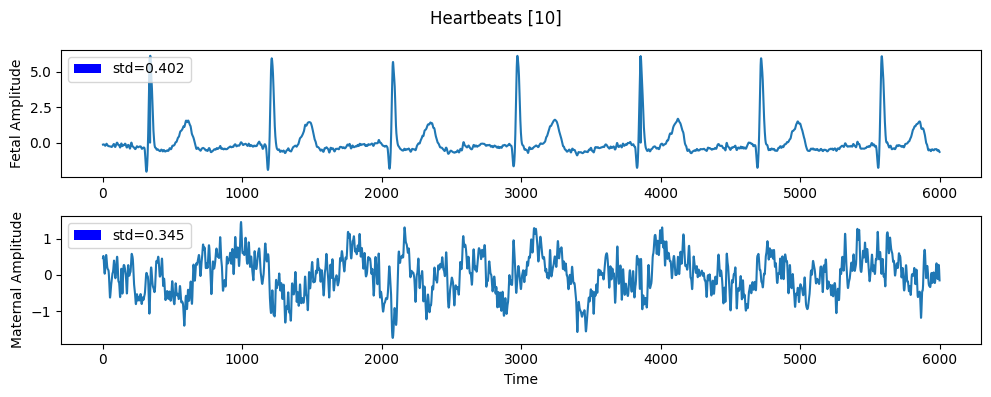

<Figure size 640x480 with 0 Axes>

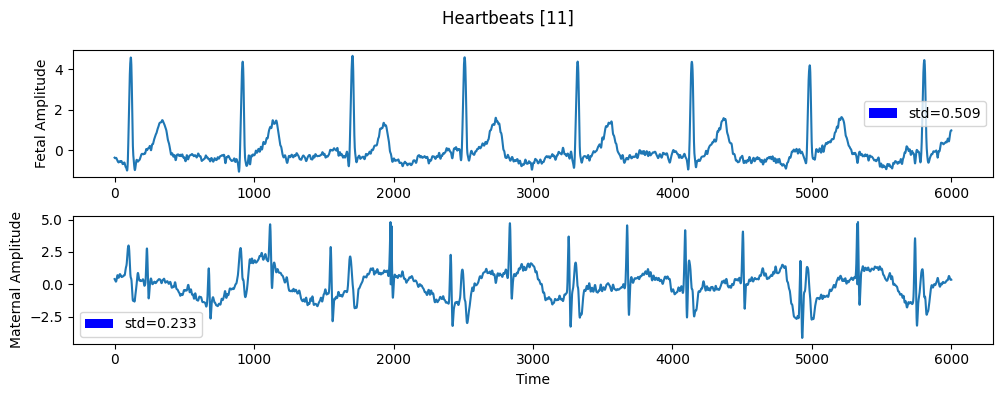

<Figure size 640x480 with 0 Axes>

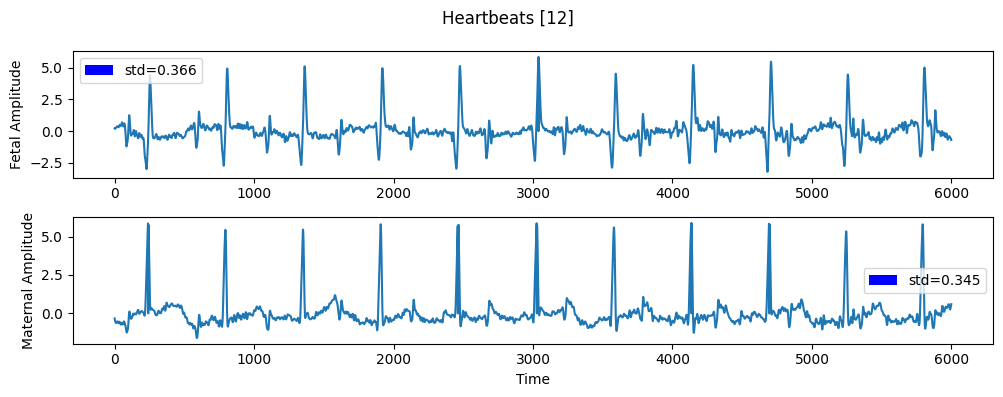

<Figure size 640x480 with 0 Axes>

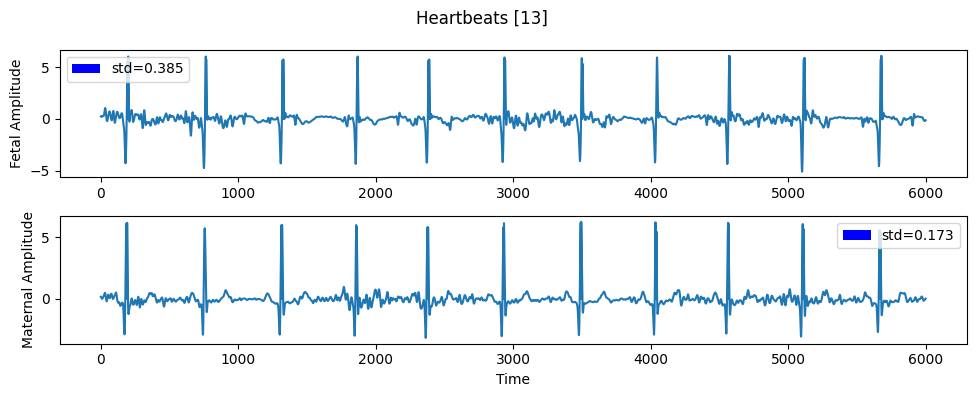

<Figure size 640x480 with 0 Axes>

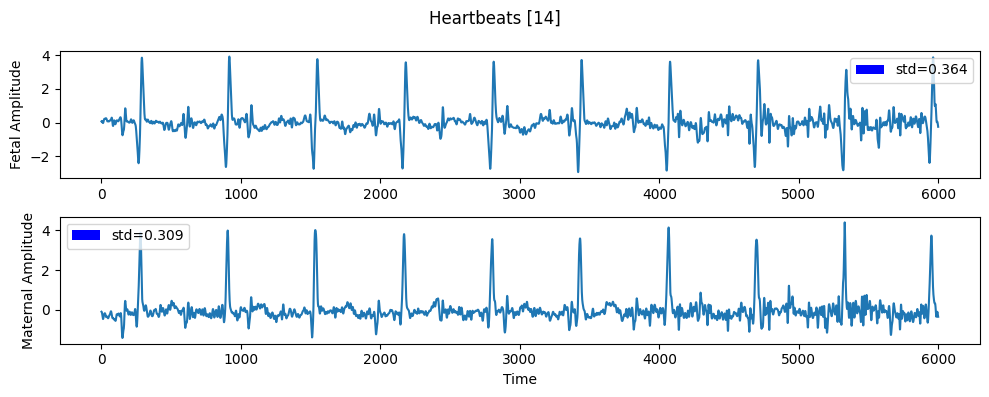

<Figure size 640x480 with 0 Axes>

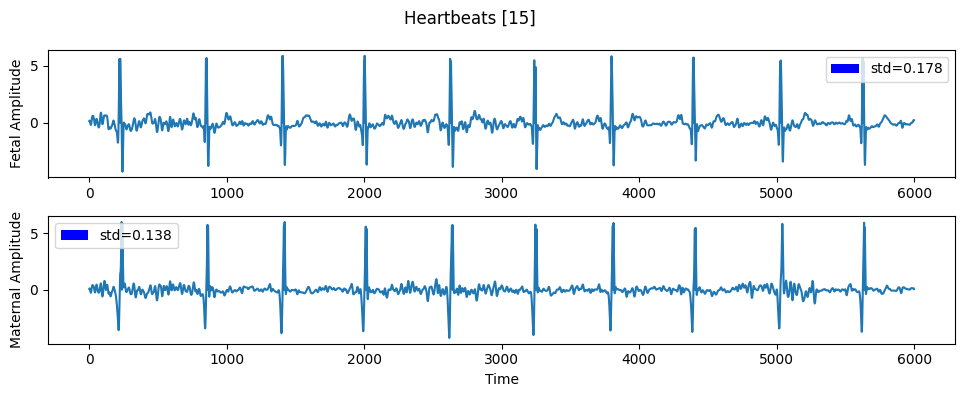

<Figure size 640x480 with 0 Axes>

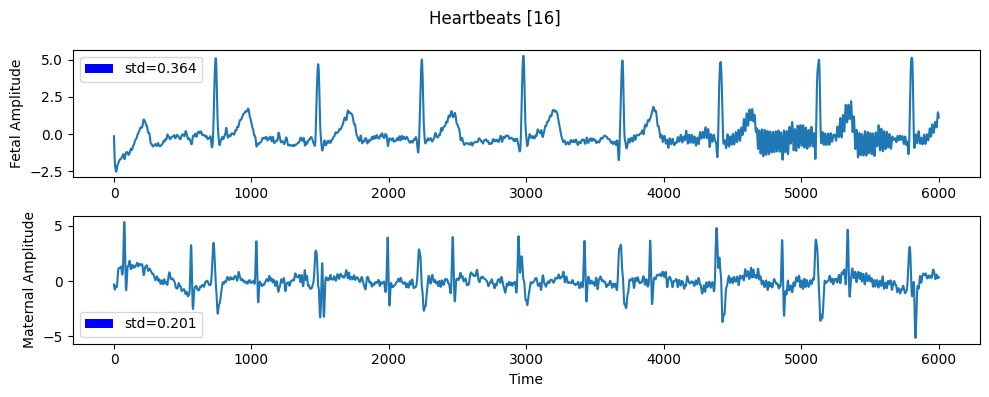

<Figure size 640x480 with 0 Axes>

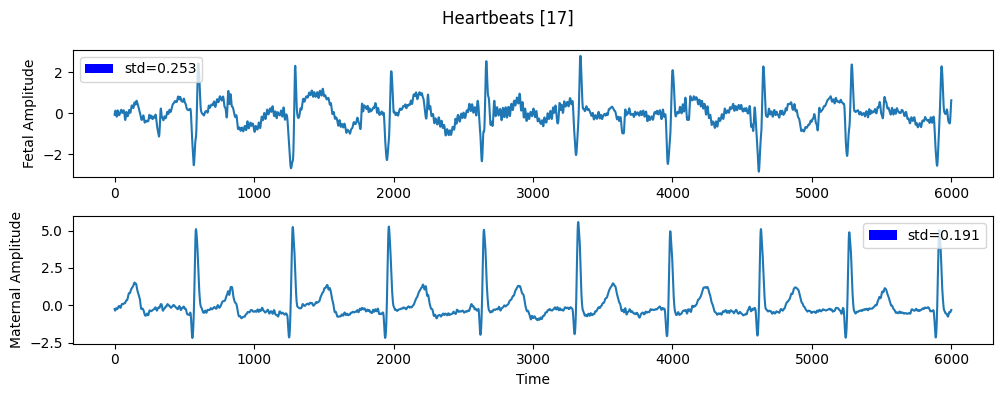

<Figure size 640x480 with 0 Axes>

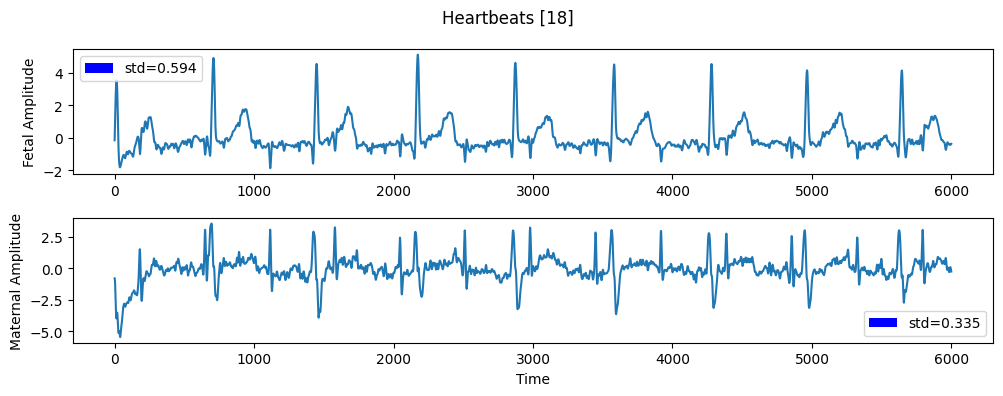

<Figure size 640x480 with 0 Axes>

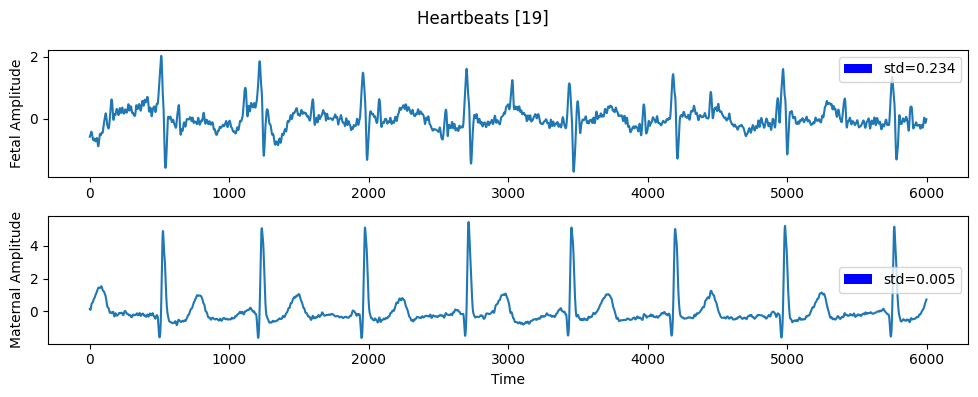

<Figure size 640x480 with 0 Axes>

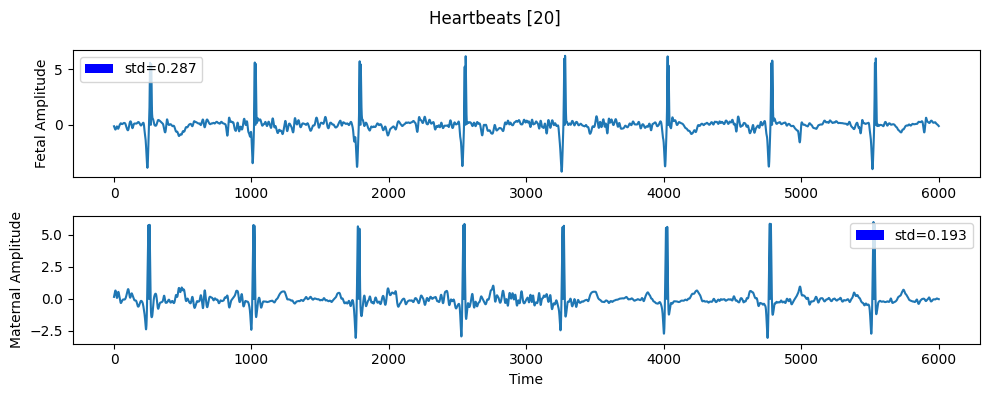

<Figure size 640x480 with 0 Axes>

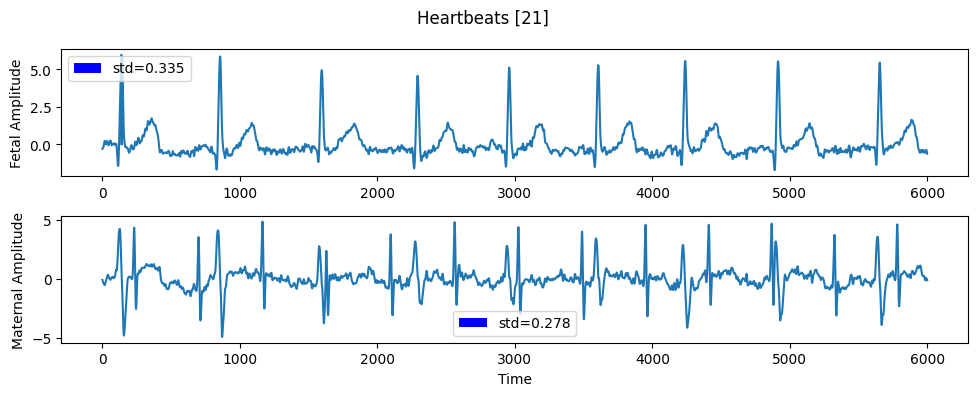

<Figure size 640x480 with 0 Axes>

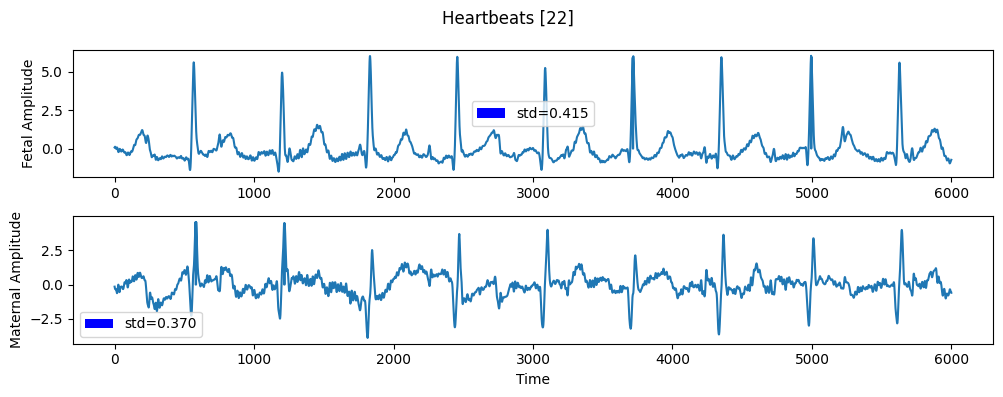

<Figure size 640x480 with 0 Axes>

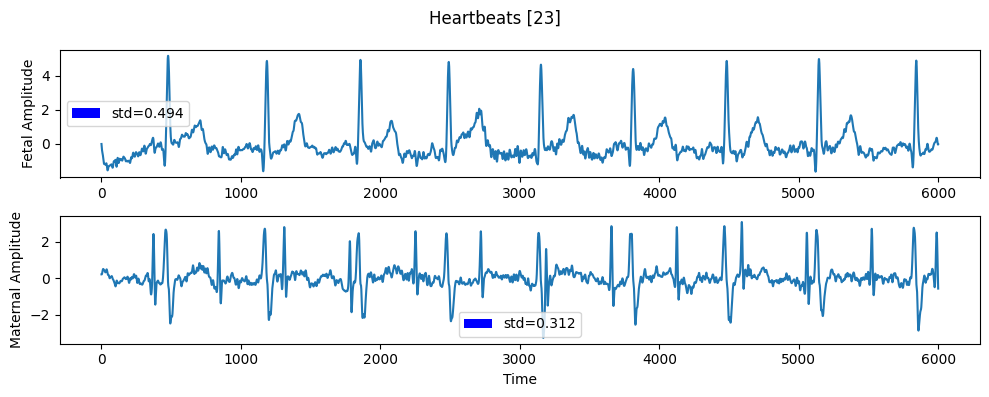

<Figure size 640x480 with 0 Axes>

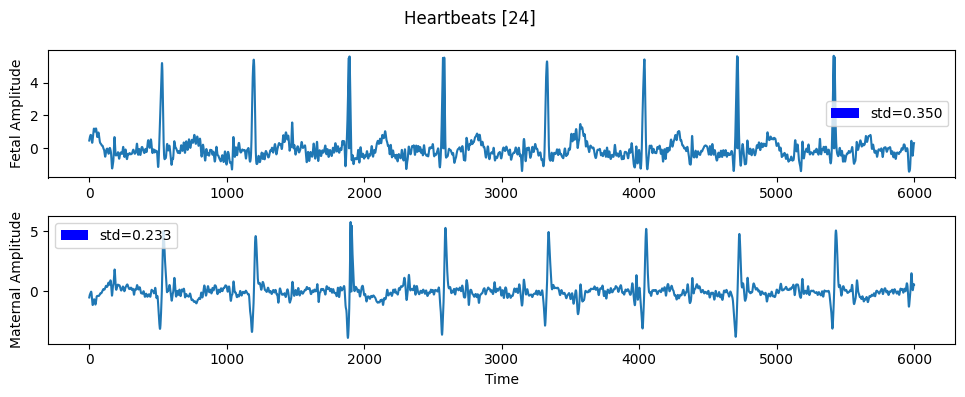

In [227]:
heartbeats_channels_arr = []
heartbeats_spiketimes_arr = []

for i in range(len(spike_channels_arr)):
    spike_channels = spike_channels_arr[i]
    spiketimes = spiketimes_arr[i]
    #np.std(spike_channels[j][spiketimes[j]])
    
    spikecounts = [len(spiketimes[k]) for k in range(len(spiketimes))]
    candidate_indices, candidate_diff = minimum_difference(spikecounts)
    if candidate_diff <= 0 and spikecounts[candidate_indices[0]] != 0:
        heartbeats_i = candidate_indices
    else:
        heartbeats_i = np.argsort(spikecounts)[2:]
    
    heartbeats_channels = np.array([spike_channels[k] for k in heartbeats_i])
    heartbeats_spiketimes = [spiketimes[k] for k in heartbeats_i]

    # sort heartbeats 0-fetal, 1-maternal
    if np.std(heartbeats_channels[0][heartbeats_spiketimes[0]]) > np.std(heartbeats_channels[1][heartbeats_spiketimes[1]]):
        heartbeats_channels = np.array([heartbeats_channels[1], heartbeats_channels[0]])
        heartbeats_spiketimes = [heartbeats_spiketimes[1], heartbeats_spiketimes[0]]

    heartbeats_channels_arr.append(heartbeats_channels)
    heartbeats_spiketimes_arr.append(heartbeats_spiketimes)
    
    plot_data_channels(heartbeats_channels, f"Heartbeats [{i}]",interval=(0,6000) ,ylabels=["Fetal Amplitude", "Maternal Amplitude"], legend_items=[f"std={(np.std(heartbeats_channels[0][heartbeats_spiketimes[0]])):.3f}",f"std={(np.std(heartbeats_channels[1][heartbeats_spiketimes[1]])):.3f}"])#, save=True, fileName=f"ica_images/{i}")

In [228]:
def get_heartbeat_windows(spike_channels, spiketimes):
    windows_arr = []
    for channel, channeltimes in zip(spike_channels, spiketimes):
        windows = []
        for i in range(len(channeltimes)-2):
            ind1 = (channeltimes[i]+channeltimes[i+1])/2
            ind2 = (channeltimes[i+1]+channeltimes[i+2])/2
            windows.append(channel[int(ind1):int(ind2)])
        windows_arr.append(windows)
    return windows_arr

def get_features(spike_channels_arr, spiketimes_arr):
    features = []
    for spike_channels, spiketimes in zip(spike_channels_arr, spiketimes_arr):
        feature = []
        # spikes/time
        #feature.append(len(spiketimes[0])/len(spike_channels[0]))
        feature.append(len(spiketimes[1])/len(spike_channels[1]))

        # average distance between spikes
        #feature.append(np.std(np.diff(spiketimes[0])))
        feature.append(np.std(np.diff(spiketimes[1])))

        #feature.append(np.trapz(spike_channels[0][spiketimes[0][0]:spiketimes[0][-1]]))

        features.append(feature)
    return np.array(features)
        
features = get_features(heartbeats_channels_arr, heartbeats_spiketimes_arr)

features = StandardScaler().fit_transform(features)




In [230]:
pca = PCA(n_components=2).fit(features)
pca_result = pca.transform(features)
#pca_result = features
print(f"Explained variance: {pca.explained_variance_ratio_}")

dbscan = DBSCAN(eps=0.25, min_samples=5)
labels = dbscan.fit_predict(pca_result)

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=-1, vmax=1)

Explained variance: [0.78933346 0.21066654]


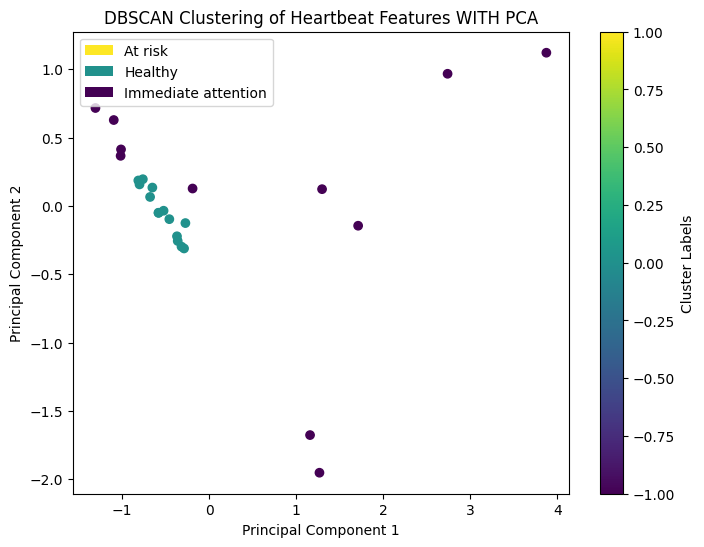

In [231]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap=cmap, norm=norm)
unique_labels = np.unique(labels)
label_counts = Counter(labels)
label_to_name = {-1: "Immediate attention", 0: "Healthy", 1: "At risk"}
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=cmap(norm(label)), label=name)
    for label, name in label_to_name.items()
][::-1]
plt.legend(handles=legend_elements)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("DBSCAN Clustering of Heartbeat Features WITH PCA")
plt.colorbar(label='Cluster Labels')
plt.show()